In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import librosa
from librosa.core.spectrum import _spectrogram
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

In [40]:
# load data
df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")
#df_resampled = pd.read_pickle("./data_for_modeling_jare59.pickle")

count    4362.000000
mean        0.309971
std         2.387125
min         0.000000
25%         0.000000
50%         0.000000
75%         0.007966
max       123.988980
Name: SPC_flux[mm], dtype: float64
4371 319 7.298101121024938
['pitch', 'Relative wind speed[m/s]', 'relative_wind_cos', 'relative_wind_sin', 'Speed[knot]', 'mwp', 't2m', 'sst', 'swh', 'u10', 'v10', 'relative_wind_y', 'tp', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 'Relative_wind_direction[deg]', 'Relative wave direction[deg]', 'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio']


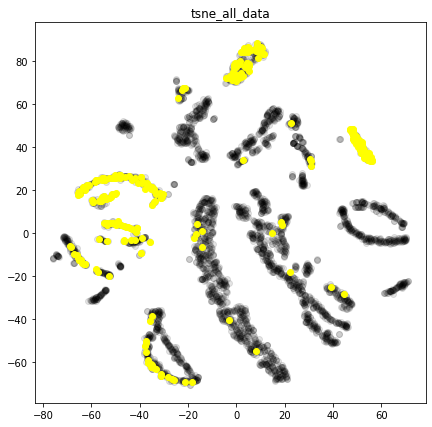

<Figure size 432x288 with 0 Axes>

In [41]:
df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")

columns = ['ピッチ (度)', 'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin', 'Speed[knot]', 'SPC_flux[mm]', 'mwp', 't2m', 'sst', 'swh', 'u10', 'v10', 'relative_wind_y', 'label', 'tp']
columns.extend([i+1 for i in range(30)])
columns.extend(['Relative_wind_direction[deg]', 'Relative wave direction[deg]', 'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio'])
df_resampled = df_resampled.loc[:, columns]

SPC_mean = df_resampled['SPC_flux[mm]'].resample("min").mean()
df_resampled_minute = df_resampled.resample("min").nearest()
df_resampled_hour = df_resampled.resample("H").nearest()
df_resampled_hour['tp'] = df_resampled_hour['tp'] * 3600
df_resampled_minute['tp'] = df_resampled_minute['tp'] * 3600
df_resampled_minute = df_resampled_minute[df_resampled_minute['tp'] < (0.01 / 1000) / 60]
df_resampled_hour = df_resampled_hour[df_resampled_hour['tp'] < (0.01 / 1000)]
df_resampled = df_resampled[df_resampled['tp'] < (0.01 / 1000) / 3600]
df_copy = df_resampled_minute
df_copy['SPC_flux[mm]'] = SPC_mean
#df_copy = df_resampled.copy()
# 飛沫データのラベリング
spray_all = np.array(df_copy['SPC_flux[mm]'])
print(df_copy['SPC_flux[mm]'].describe())
# 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
spc_label = [1 if i > 0.5 else 0 for i in spray_all]
df_copy['label'] = spc_label
print(len(df_copy), len(df_copy[df_copy['label'] != 0.0]), len(df_copy[df_copy['label'] != 0.0]) / len(df_copy) * 100)
df_copy = df_copy.rename(columns={'ピッチ (度)':'pitch', '相対風速 (m/s)_sin':'relative_wind_sin', '相対風速 (m/s)_cos':'relative_wind_cos'})

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

#for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
for_modeling = all_columns
#for_modeling.remove('tp')
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
#label = np.array(df_copy['label'])

#X = df_copy.loc[:, [i for i in df_copy.columns if i != 'SPC_flux[mm]' and i != 'label']]
#print(X.columns)
y = df_copy.loc[:, "label"]

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=100,
                                     file_path='/home/nt/Desktop/soturon'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        tsne = TSNE(n_components=2, random_state=random_state)
        transformed = tsne.fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    #print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title(image_name)
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))


plot_reduced_graph(X, y, 'tsne_all_data', model='tsne', random_sampling=False, random_state=200)

# 普通にlightgbm

In [179]:
def fix_df(df_resampled, th_spc):
    columns = ['ピッチ (度)', 'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin', 'Speed[knot]', 'SPC_flux[mm]', 'mwp', 't2m', 'sst', 'swh', 'u10', 'v10', 'relative_wind_y', 'label', 'tp']
    columns.extend([i+1 for i in range(30)])
    columns.extend(['Relative_wind_direction[deg]', 'Relative wave direction[deg]', 'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio'])
    df_resampled = df_resampled.loc[:, columns]

    SPC_mean = df_resampled['SPC_flux[mm]'].resample("min").mean()
    df_resampled_minute = df_resampled.resample("min").nearest()
    df_resampled_hour = df_resampled.resample("H").nearest()
    df_resampled_hour['tp'] = df_resampled_hour['tp'] * 3600
    df_resampled_minute['tp'] = df_resampled_minute['tp'] * 3600
    df_resampled_minute = df_resampled_minute[df_resampled_minute['tp'] < (0.01 / 1000) / 60]
    df_resampled_hour = df_resampled_hour[df_resampled_hour['tp'] < (0.01 / 1000)]
    df_resampled = df_resampled[df_resampled['tp'] < (0.01 / 1000) / 3600]
    df_copy = df_resampled_minute
    df_copy['SPC_flux[mm]'] = SPC_mean
    #df_copy = df_resampled.copy()
    # 飛沫データのラベリング
    spray_all = np.array(df_copy['SPC_flux[mm]'])
    #print(df_copy['SPC_flux[mm]'].describe())
    # 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
    spc_label = [1 if i > th_spc else 0 for i in spray_all]
    df_copy['label'] = spc_label
    #print(len(df_copy), len(df_copy[df_copy['label'] != 0.0]), len(df_copy[df_copy['label'] != 0.0]) / len(df_copy) * 100)
    df_copy = df_copy.rename(columns={'ピッチ (度)':'pitch', '相対風速 (m/s)_sin':'relative_wind_sin', '相対風速 (m/s)_cos':'relative_wind_cos'})
    return df_copy

# 実験版

In [234]:
df_resampled.columns

Index([                     'ピッチ (度)',                  '中央Ax (m/s2)',
                        '中央Ay (m/s2)',                  '中央Az (m/s2)',
                          '南北速度 (kt)',               '右散水流量 (m3/min)',
                              '回転数調整',               '左散水流量 (m3/min)',
                          '東西速度 (kt)',     'Relative wind speed[m/s]',
                     '相対風速 (m/s)_cos',               '相対風速 (m/s)_sin',
                          '舵角　右舵 (度)',                    '舵角　左舵 (度)',
                        '船尾Ax (m/s2)',                  '船尾Ay (m/s2)',
                        '船尾Az (m/s2)',                  '船首Ax (m/s2)',
                        '船首Ay (m/s2)',                  '船首Az (m/s2)',
                        'Course[deg]',                  'Speed[knot]',
                       'SPC_flux[mm]',                          'mwp',
                                't2m',                          'sst',
                                'mwd',                           'tp',
      

In [251]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
import pickle 

th_spc_all = []
f_score_all = []
cms_all = []
recall_all = []
precision_all = []
accuracy_all = []
th_list_all = []

df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")
df_resampled_ = pd.read_pickle("./data_for_modeling_jare59.pickle")
#th_spcs = [0.01 + 0.01 * k for k in range(100)]
#th_spcs = [0.2, 0.25]
th_spcs = [0.29]

for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['swh', 'mwp']
#for_modeling = ['swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['ratio', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
for_modeling.extend([i+1 for i in range(10)])
#for_modeling = all_columns
    
for th_spc in th_spcs:
    df_copy = fix_df(df_resampled, th_spc)
#     print(for_modeling)
    X = df_copy.loc[:, for_modeling]
    X = np.array(X)
    y = np.array(df_copy['label'])


    # # SMOTE to balance dataset
#     sm = SMOTE()
#     X, y = sm.fit_sample(X, y)

#     date = datetime.now()
#     seed1 = date.minute + date.second + date.hour
    seed1 = 1
#     print(seed1)

    def imbalanced_data_split(X, y, seed, test_size=0.2):
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
        #sss = StratifiedKFold(n_splits=5, random_state=None)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            return X_train, X_test, y_train, y_test

    X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1)
    # for validation
    X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

    print("jare60データ総数：{}, 飛沫あり区間：{}, 割合：{}".format(len(y_train), len(y_train[y_train==1]), len(y_train[y_train==1])/len(y_train) * 100))

    lgbm_params = {
        'learning_rate': 0.01,
        'num_leaves': 8,
        'max_depth':5,
        'verbose':-1,
        'boosting_type' : 'gbdt',
        'reg_alpha' : 1,
        'reg_lambda' : 1,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': 8
    }

    def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
        lgb_train = lgb.Dataset(X_train_df, y_train_df)
        lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

        # 上記のパラメータでモデルを学習する
        model = lgb.train(lgbm_params, lgb_train,
                          # モデルの評価用データを渡す
                          valid_sets=lgb_eval,
                          # 最大で 1000 ラウンドまで学習する
                          num_boost_round=1000,
                          # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                          early_stopping_rounds=10)

        return model

    model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

#     y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
#     y_pred_binary = []
#     for p in y_pred:
#         if p >= 0.2:
#             y_pred_binary.append(1)
#         else:
#             y_pred_binary.append(0)

#     cm = confusion_matrix(y_test, y_pred_binary)
#     print(cm)
#     print("accuracy: ", accuracy_score(y_pred_binary, y_test))
#     print("recall:", recall_score(y_pred_binary, y_test))
#     print("precision:", precision_score(y_pred_binary, y_test))
#     print("f1_score:", f1_score(y_pred_binary, y_test))

    #file = 'lightgbm_jare60.pkl'
    #pickle.dump(model_normal, open(file, 'wb'))

    df_copy_ = fix_df(df_resampled_, th_spc)

    #file = 'lightgbm_jare60.pkl'
    #model_normal = pickle.load(open(file, 'rb'))
#     print(for_modeling)
    X_ = df_copy_.loc[:, for_modeling]
    X_ = np.array(X_)
    y_ = np.array(df_copy_['label'])
    print("jare59データ総数：{}, 飛沫あり区間数：{}, 割合：{}".format(len(y_), len(y_[y_==1]), len(y_[y_==1])/len(y_) * 100))

    y_pred_ = model_normal.predict(X_, num_iteration=model_normal.best_iteration)

    f_score = []
    cms = []
    recall = []
    precision = []
    accuracy = []
    th_list = []
    ans = 0
    
    for j in range(1):
        th = 0.01 + 0.01 * j
        th = 0.1
        th_list.append(th)
        y_pred_binary = []
        for p in y_pred_:
            if p >= th:
                y_pred_binary.append(1)
            else:
                y_pred_binary.append(0)


        accuracy.append(accuracy_score(y_pred_binary, y_))
        f_score.append(f1_score(y_pred_binary, y_))
        recall.append(recall_score(y_pred_binary, y_))
        precision.append(precision_score(y_pred_binary, y_))
        cm = confusion_matrix(y_, y_pred_binary)
        cms.append(cm)
        
    th_spc_all.append(th_spc)
    th_list_all.append(th_list[np.argmax(f_score)])
    accuracy_all.append(accuracy[np.argmax(f_score)])
    f_score_all.append(max(f_score))
    recall_all.append(recall[np.argmax(f_score)])
    precision_all.append(precision[np.argmax(f_score)])
    cm = confusion_matrix(y_, y_pred_binary)
    cms_all.append(cms[np.argmax(f_score)]) 
    
print("th_spc ", th_spc_all[np.argmax(f_score_all)])
print("th ", th_list_all[np.argmax(f_score_all)])
print("f_score ", max(f_score_all))
print("accuracy ", accuracy_all[np.argmax(f_score_all)])
print("precision ", precision_all[np.argmax(f_score_all)])
print("recall ", recall_all[np.argmax(f_score_all)])

cm = confusion_matrix(y_, y_pred_binary)
print("cm ", cms_all[np.argmax(f_score_all)]) 

jare60データ総数：3496, 飛沫あり区間：455, 割合：13.014874141876431
[1]	valid_0's binary_logloss: 0.38458
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382834
[3]	valid_0's binary_logloss: 0.381144
[4]	valid_0's binary_logloss: 0.379507
[5]	valid_0's binary_logloss: 0.377921
[6]	valid_0's binary_logloss: 0.376383
[7]	valid_0's binary_logloss: 0.37489
[8]	valid_0's binary_logloss: 0.373203
[9]	valid_0's binary_logloss: 0.371566
[10]	valid_0's binary_logloss: 0.369977
[11]	valid_0's binary_logloss: 0.368435
[12]	valid_0's binary_logloss: 0.366936
[13]	valid_0's binary_logloss: 0.365469
[14]	valid_0's binary_logloss: 0.364052
[15]	valid_0's binary_logloss: 0.362663
[16]	valid_0's binary_logloss: 0.361312
[17]	valid_0's binary_logloss: 0.360067
[18]	valid_0's binary_logloss: 0.358785
[19]	valid_0's binary_logloss: 0.357676
[20]	valid_0's binary_logloss: 0.356527
[21]	valid_0's binary_logloss: 0.355449
[22]	valid_0's binary_logloss: 0.354357
[23]	valid_0's bin

In [233]:
df_resampled.corr().loc[:, "SPC_flux[mm]"]

ピッチ (度)                         0.002355
中央Ax (m/s2)                     0.031160
中央Ay (m/s2)                    -0.012464
中央Az (m/s2)                     0.001851
南北速度 (kt)                       0.021062
                                  ...   
Relative wave direction[deg]   -0.025066
Speed[m/s]                     -0.078753
encounter cycle                 0.001934
wave_length                    -0.035442
ratio                          -0.035442
Name: SPC_flux[mm], Length: 69, dtype: float64

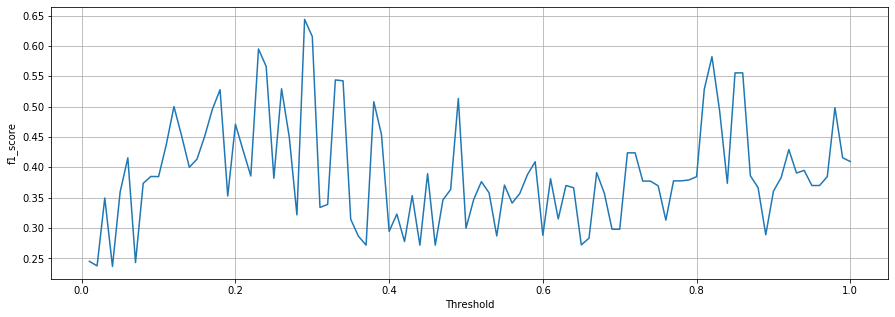

In [216]:
plt.figure(figsize=(15, 5))
plt.plot(th_spc_all, f_score_all)
plt.grid(True)
plt.xlabel("Threshold")
plt.ylabel("f1_score")
plt.savefig("threshold.png")

# 100iteration用

In [213]:
##### from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
import pickle 

th_spc_all = []
f_score_all = []
cms_all = []
recall_all = []
precision_all = []
accuracy_all = []
th_list_all = []

df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")
df_resampled_ = pd.read_pickle("./data_for_modeling_jare59.pickle")
#th_spcs = [0.01 + 0.01 * k for k in range(100)]
#th_spcs = [0.2, 0.25]

for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
for_modeling.extend([i+1 for i in range(30)])
#for_modeling = all_columns
#th_spcs = [0.21 + 0.01 * k for k in range(10)]
th_spcs = [0.24]
ths = [0.01 + 0.03 * k for k in range(10)]
tmp = []
#for th_spc in th_spcs:
for th in ths:
    th_spc_all = []
    f_score_all = []
    cms_all = []
    recall_all = []
    precision_all = []
    accuracy_all = []
    th_list_all = []
    for epoch in range(10):
        df_copy = fix_df(df_resampled, th_spc)
    #     print(for_modeling)
        X = df_copy.loc[:, for_modeling]
        X = np.array(X)
        y = np.array(df_copy['label'])


        # # SMOTE to balance dataset
#         sm = SMOTE()
#         X, y = sm.fit_sample(X, y)

#         date = datetime.now()
#         seed1 = date.minute + date.second + date.hour
        seed1 = 1
    #     print(seed1)

        def imbalanced_data_split(X, y, seed, test_size=0.2):
            sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
            #sss = StratifiedKFold(n_splits=5, random_state=None)
            for train_index, test_index in sss.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                return X_train, X_test, y_train, y_test

        X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1)
        # for validation
        X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

    #     print(len(y_train), len(y_test), len(y_train2), len(y_valid))

        lgbm_params = {
            'learning_rate': 0.01,
            'num_leaves': 8,
            'max_depth':8,
            'verbose':-1,
            'boosting_type' : 'gbdt',
            'reg_alpha' : 1,
            'reg_lambda' : 1,
            'objective': 'binary',
            'metric': 'binary_logloss',
            'num_threads': 8
        }

        def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
            lgb_train = lgb.Dataset(X_train_df, y_train_df)
            lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

            # 上記のパラメータでモデルを学習する
            model = lgb.train(lgbm_params, lgb_train,
                              # モデルの評価用データを渡す
                              valid_sets=lgb_eval,
                              # 最大で 1000 ラウンドまで学習する
                              num_boost_round=1000,
                              # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                              early_stopping_rounds=10)

            return model

        model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

    #     y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
    #     y_pred_binary = []
    #     for p in y_pred:
    #         if p >= 0.2:
    #             y_pred_binary.append(1)
    #         else:
    #             y_pred_binary.append(0)

    #     cm = confusion_matrix(y_test, y_pred_binary)
    #     print(cm)
    #     print("accuracy: ", accuracy_score(y_pred_binary, y_test))
    #     print("recall:", recall_score(y_pred_binary, y_test))
    #     print("precision:", precision_score(y_pred_binary, y_test))
    #     print("f1_score:", f1_score(y_pred_binary, y_test))

        #file = 'lightgbm_jare60.pkl'
        #pickle.dump(model_normal, open(file, 'wb'))

        df_copy_ = fix_df(df_resampled_, th_spc)

        #file = 'lightgbm_jare60.pkl'
        #model_normal = pickle.load(open(file, 'rb'))

    #     print(for_modeling)
        X_ = df_copy_.loc[:, for_modeling]
        X_ = np.array(X_)
        y_ = np.array(df_copy_['label'])

        y_pred_ = model_normal.predict(X_, num_iteration=model_normal.best_iteration)

        f_score = []
        cms = []
        recall = []
        precision = []
        accuracy = []
        th_list = []
        ans = 0

        for j in range(1):
            #th = 0.01 + 0.01 * j
#             th = 0.12
            th_list.append(th)
            y_pred_binary = []
            for p in y_pred_:
                if p >= th:
                    y_pred_binary.append(1)
                else:
                    y_pred_binary.append(0)


            accuracy.append(accuracy_score(y_pred_binary, y_))
            f_score.append(f1_score(y_pred_binary, y_))
            recall.append(recall_score(y_pred_binary, y_))
            precision.append(precision_score(y_pred_binary, y_))
            cm = confusion_matrix(y_, y_pred_binary)
            cms.append(cm)

        th_spc_all.append(th_spc)
        th_list_all.append(th_list[np.argmax(f_score)])
        accuracy_all.append(accuracy[np.argmax(f_score)])
        f_score_all.append(max(f_score))
        recall_all.append(recall[np.argmax(f_score)])
        precision_all.append(precision[np.argmax(f_score)])
        cm = confusion_matrix(y_, y_pred_binary)
        cms_all.append(cms[np.argmax(f_score)]) 
    tmp.append(np.mean(f_score_all))
        
    print("********************************************************************************************************************")
    print("th_spc ", th_spc)
    print("th ", np.mean(th_list_all))
    print("f_score ", np.mean(f_score_all))
    print("accuracy ", np.mean(accuracy_all))
    print("precision ", np.mean(precision_all))
    print("recall ", np.mean(recall_all))

[1]	valid_0's binary_logloss: 0.384268
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382211
[3]	valid_0's binary_logloss: 0.380199
[4]	valid_0's binary_logloss: 0.378259
[5]	valid_0's binary_logloss: 0.376389
[6]	valid_0's binary_logloss: 0.374584
[7]	valid_0's binary_logloss: 0.372841
[8]	valid_0's binary_logloss: 0.371155
[9]	valid_0's binary_logloss: 0.369526
[10]	valid_0's binary_logloss: 0.367948
[11]	valid_0's binary_logloss: 0.366421
[12]	valid_0's binary_logloss: 0.364923
[13]	valid_0's binary_logloss: 0.36347
[14]	valid_0's binary_logloss: 0.362032
[15]	valid_0's binary_logloss: 0.360682
[16]	valid_0's binary_logloss: 0.359354
[17]	valid_0's binary_logloss: 0.358065
[18]	valid_0's binary_logloss: 0.3568
[19]	valid_0's binary_logloss: 0.355581
[20]	valid_0's binary_logloss: 0.354396
[21]	valid_0's binary_logloss: 0.353217
[22]	valid_0's binary_logloss: 0.352111
[23]	valid_0's binary_logloss: 0.35102
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384451
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.38258
[3]	valid_0's binary_logloss: 0.380772
[4]	valid_0's binary_logloss: 0.378964
[5]	valid_0's binary_logloss: 0.377182
[6]	valid_0's binary_logloss: 0.375323
[7]	valid_0's binary_logloss: 0.373527
[8]	valid_0's binary_logloss: 0.371788
[9]	valid_0's binary_logloss: 0.370105
[10]	valid_0's binary_logloss: 0.368487
[11]	valid_0's binary_logloss: 0.367194
[12]	valid_0's binary_logloss: 0.365848
[13]	valid_0's binary_logloss: 0.364427
[14]	valid_0's binary_logloss: 0.36324
[15]	valid_0's binary_logloss: 0.361991
[16]	valid_0's binary_logloss: 0.360778
[17]	valid_0's binary_logloss: 0.359516
[18]	valid_0's binary_logloss: 0.35846
[19]	valid_0's binary_logloss: 0.357266
[20]	valid_0's binary_logloss: 0.356262
[21]	valid_0's binary_logloss: 0.355232
[22]	valid_0's binary_logloss: 0.354116
[23]	valid_0's binary_logloss: 0.353185
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384451
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.38258
[3]	valid_0's binary_logloss: 0.380772
[4]	valid_0's binary_logloss: 0.378964
[5]	valid_0's binary_logloss: 0.377182
[6]	valid_0's binary_logloss: 0.375323
[7]	valid_0's binary_logloss: 0.373527
[8]	valid_0's binary_logloss: 0.371788
[9]	valid_0's binary_logloss: 0.370105
[10]	valid_0's binary_logloss: 0.368487
[11]	valid_0's binary_logloss: 0.367194
[12]	valid_0's binary_logloss: 0.365848
[13]	valid_0's binary_logloss: 0.364427
[14]	valid_0's binary_logloss: 0.36324
[15]	valid_0's binary_logloss: 0.361991
[16]	valid_0's binary_logloss: 0.360778
[17]	valid_0's binary_logloss: 0.359516
[18]	valid_0's binary_logloss: 0.35846
[19]	valid_0's binary_logloss: 0.357266
[20]	valid_0's binary_logloss: 0.356262
[21]	valid_0's binary_logloss: 0.355232
[22]	valid_0's binary_logloss: 0.354116
[23]	valid_0's binary_logloss: 0.353185
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384552
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382842
[3]	valid_0's binary_logloss: 0.381073
[4]	valid_0's binary_logloss: 0.379469
[5]	valid_0's binary_logloss: 0.377804
[6]	valid_0's binary_logloss: 0.376191
[7]	valid_0's binary_logloss: 0.374728
[8]	valid_0's binary_logloss: 0.373311
[9]	valid_0's binary_logloss: 0.371827
[10]	valid_0's binary_logloss: 0.370491
[11]	valid_0's binary_logloss: 0.369087
[12]	valid_0's binary_logloss: 0.367735
[13]	valid_0's binary_logloss: 0.366405
[14]	valid_0's binary_logloss: 0.365112
[15]	valid_0's binary_logloss: 0.363865
[16]	valid_0's binary_logloss: 0.362637
[17]	valid_0's binary_logloss: 0.361301
[18]	valid_0's binary_logloss: 0.360002
[19]	valid_0's binary_logloss: 0.358741
[20]	valid_0's binary_logloss: 0.357514
[21]	valid_0's binary_logloss: 0.356321
[22]	valid_0's binary_logloss: 0.355161
[23]	valid_0's binary_logloss: 0.354031
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.384552
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382842
[3]	valid_0's binary_logloss: 0.381073
[4]	valid_0's binary_logloss: 0.379469
[5]	valid_0's binary_logloss: 0.377804
[6]	valid_0's binary_logloss: 0.376191
[7]	valid_0's binary_logloss: 0.374728
[8]	valid_0's binary_logloss: 0.373311
[9]	valid_0's binary_logloss: 0.371827
[10]	valid_0's binary_logloss: 0.370491
[11]	valid_0's binary_logloss: 0.369087
[12]	valid_0's binary_logloss: 0.367735
[13]	valid_0's binary_logloss: 0.366405
[14]	valid_0's binary_logloss: 0.365112
[15]	valid_0's binary_logloss: 0.363865
[16]	valid_0's binary_logloss: 0.362637
[17]	valid_0's binary_logloss: 0.361301
[18]	valid_0's binary_logloss: 0.360002
[19]	valid_0's binary_logloss: 0.358741
[20]	valid_0's binary_logloss: 0.357514
[21]	valid_0's binary_logloss: 0.356321
[22]	valid_0's binary_logloss: 0.355161
[23]	valid_0's binary_logloss: 0.354031
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.384215
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382128
[3]	valid_0's binary_logloss: 0.380134
[4]	valid_0's binary_logloss: 0.378197
[5]	valid_0's binary_logloss: 0.376324
[6]	valid_0's binary_logloss: 0.374522
[7]	valid_0's binary_logloss: 0.372713
[8]	valid_0's binary_logloss: 0.37096
[9]	valid_0's binary_logloss: 0.369262
[10]	valid_0's binary_logloss: 0.367643
[11]	valid_0's binary_logloss: 0.366045
[12]	valid_0's binary_logloss: 0.364493
[13]	valid_0's binary_logloss: 0.362985
[14]	valid_0's binary_logloss: 0.361548
[15]	valid_0's binary_logloss: 0.360124
[16]	valid_0's binary_logloss: 0.358738
[17]	valid_0's binary_logloss: 0.35739
[18]	valid_0's binary_logloss: 0.356105
[19]	valid_0's binary_logloss: 0.354828
[20]	valid_0's binary_logloss: 0.353583
[21]	valid_0's binary_logloss: 0.352397
[22]	valid_0's binary_logloss: 0.351215
[23]	valid_0's binary_logloss: 0.350063
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384215
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382128
[3]	valid_0's binary_logloss: 0.380134
[4]	valid_0's binary_logloss: 0.378197
[5]	valid_0's binary_logloss: 0.376324
[6]	valid_0's binary_logloss: 0.374522
[7]	valid_0's binary_logloss: 0.372713
[8]	valid_0's binary_logloss: 0.37096
[9]	valid_0's binary_logloss: 0.369262
[10]	valid_0's binary_logloss: 0.367643
[11]	valid_0's binary_logloss: 0.366045
[12]	valid_0's binary_logloss: 0.364493
[13]	valid_0's binary_logloss: 0.362985
[14]	valid_0's binary_logloss: 0.361548
[15]	valid_0's binary_logloss: 0.360124
[16]	valid_0's binary_logloss: 0.358738
[17]	valid_0's binary_logloss: 0.35739
[18]	valid_0's binary_logloss: 0.356105
[19]	valid_0's binary_logloss: 0.354828
[20]	valid_0's binary_logloss: 0.353583
[21]	valid_0's binary_logloss: 0.352397
[22]	valid_0's binary_logloss: 0.351215
[23]	valid_0's binary_logloss: 0.350063
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384554
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382814
[3]	valid_0's binary_logloss: 0.381136
[4]	valid_0's binary_logloss: 0.379379
[5]	valid_0's binary_logloss: 0.377782
[6]	valid_0's binary_logloss: 0.376196
[7]	valid_0's binary_logloss: 0.3747
[8]	valid_0's binary_logloss: 0.373208
[9]	valid_0's binary_logloss: 0.37183
[10]	valid_0's binary_logloss: 0.370288
[11]	valid_0's binary_logloss: 0.368795
[12]	valid_0's binary_logloss: 0.367347
[13]	valid_0's binary_logloss: 0.365944
[14]	valid_0's binary_logloss: 0.364582
[15]	valid_0's binary_logloss: 0.363261
[16]	valid_0's binary_logloss: 0.361977
[17]	valid_0's binary_logloss: 0.36073
[18]	valid_0's binary_logloss: 0.359518
[19]	valid_0's binary_logloss: 0.358339
[20]	valid_0's binary_logloss: 0.357193
[21]	valid_0's binary_logloss: 0.35616
[22]	valid_0's binary_logloss: 0.355158
[23]	valid_0's binary_logloss: 0.354185
[24]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.384554
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382814
[3]	valid_0's binary_logloss: 0.381136
[4]	valid_0's binary_logloss: 0.379379
[5]	valid_0's binary_logloss: 0.377782
[6]	valid_0's binary_logloss: 0.376196
[7]	valid_0's binary_logloss: 0.3747
[8]	valid_0's binary_logloss: 0.373208
[9]	valid_0's binary_logloss: 0.37183
[10]	valid_0's binary_logloss: 0.370288
[11]	valid_0's binary_logloss: 0.368795
[12]	valid_0's binary_logloss: 0.367347
[13]	valid_0's binary_logloss: 0.365944
[14]	valid_0's binary_logloss: 0.364582
[15]	valid_0's binary_logloss: 0.363261
[16]	valid_0's binary_logloss: 0.361977
[17]	valid_0's binary_logloss: 0.36073
[18]	valid_0's binary_logloss: 0.359518
[19]	valid_0's binary_logloss: 0.358339
[20]	valid_0's binary_logloss: 0.357193
[21]	valid_0's binary_logloss: 0.35616
[22]	valid_0's binary_logloss: 0.355158
[23]	valid_0's binary_logloss: 0.354185
[24]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.38438
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382442
[3]	valid_0's binary_logloss: 0.380455
[4]	valid_0's binary_logloss: 0.378532
[5]	valid_0's binary_logloss: 0.376669
[6]	valid_0's binary_logloss: 0.374863
[7]	valid_0's binary_logloss: 0.373112
[8]	valid_0's binary_logloss: 0.371412
[9]	valid_0's binary_logloss: 0.369761
[10]	valid_0's binary_logloss: 0.368157
[11]	valid_0's binary_logloss: 0.366598
[12]	valid_0's binary_logloss: 0.365082
[13]	valid_0's binary_logloss: 0.363698
[14]	valid_0's binary_logloss: 0.36226
[15]	valid_0's binary_logloss: 0.360859
[16]	valid_0's binary_logloss: 0.359495
[17]	valid_0's binary_logloss: 0.358165
[18]	valid_0's binary_logloss: 0.35687
[19]	valid_0's binary_logloss: 0.35569
[20]	valid_0's binary_logloss: 0.354475
[21]	valid_0's binary_logloss: 0.353291
[22]	valid_0's binary_logloss: 0.352136
[23]	valid_0's binary_logloss: 0.35101
[24]	valid_0's binary_logloss: 0.

********************************************************************************************************************
th_spc  0.3
th  0.009999999999999998
f_score  0.14602935641701167
accuracy  0.07876573284612262
precision  1.0
recall  0.07876573284612262
[1]	valid_0's binary_logloss: 0.384587
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382849
[3]	valid_0's binary_logloss: 0.381173
[4]	valid_0's binary_logloss: 0.379556
[5]	valid_0's binary_logloss: 0.377971
[6]	valid_0's binary_logloss: 0.376461
[7]	valid_0's binary_logloss: 0.375001
[8]	valid_0's binary_logloss: 0.373737
[9]	valid_0's binary_logloss: 0.372343
[10]	valid_0's binary_logloss: 0.371159
[11]	valid_0's binary_logloss: 0.370013
[12]	valid_0's binary_logloss: 0.368902
[13]	valid_0's binary_logloss: 0.367664
[14]	valid_0's binary_logloss: 0.366484
[15]	valid_0's binary_logloss: 0.365339
[16]	valid_0's binary_logloss: 0.364226
[17]	valid_0's binary_logloss: 0.363124
[18]	valid_0

[1]	valid_0's binary_logloss: 0.384587
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382849
[3]	valid_0's binary_logloss: 0.381173
[4]	valid_0's binary_logloss: 0.379556
[5]	valid_0's binary_logloss: 0.377971
[6]	valid_0's binary_logloss: 0.376461
[7]	valid_0's binary_logloss: 0.375001
[8]	valid_0's binary_logloss: 0.373737
[9]	valid_0's binary_logloss: 0.372343
[10]	valid_0's binary_logloss: 0.371159
[11]	valid_0's binary_logloss: 0.370013
[12]	valid_0's binary_logloss: 0.368902
[13]	valid_0's binary_logloss: 0.367664
[14]	valid_0's binary_logloss: 0.366484
[15]	valid_0's binary_logloss: 0.365339
[16]	valid_0's binary_logloss: 0.364226
[17]	valid_0's binary_logloss: 0.363124
[18]	valid_0's binary_logloss: 0.362073
[19]	valid_0's binary_logloss: 0.361051
[20]	valid_0's binary_logloss: 0.360057
[21]	valid_0's binary_logloss: 0.35907
[22]	valid_0's binary_logloss: 0.358129
[23]	valid_0's binary_logloss: 0.357214
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.38453
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382739
[3]	valid_0's binary_logloss: 0.38101
[4]	valid_0's binary_logloss: 0.379342
[5]	valid_0's binary_logloss: 0.37773
[6]	valid_0's binary_logloss: 0.376171
[7]	valid_0's binary_logloss: 0.374456
[8]	valid_0's binary_logloss: 0.372796
[9]	valid_0's binary_logloss: 0.371189
[10]	valid_0's binary_logloss: 0.369631
[11]	valid_0's binary_logloss: 0.36812
[12]	valid_0's binary_logloss: 0.366654
[13]	valid_0's binary_logloss: 0.365231
[14]	valid_0's binary_logloss: 0.363849
[15]	valid_0's binary_logloss: 0.362505
[16]	valid_0's binary_logloss: 0.361199
[17]	valid_0's binary_logloss: 0.359928
[18]	valid_0's binary_logloss: 0.358691
[19]	valid_0's binary_logloss: 0.357487
[20]	valid_0's binary_logloss: 0.356315
[21]	valid_0's binary_logloss: 0.355173
[22]	valid_0's binary_logloss: 0.35406
[23]	valid_0's binary_logloss: 0.353002
[24]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.38453
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382739
[3]	valid_0's binary_logloss: 0.38101
[4]	valid_0's binary_logloss: 0.379342
[5]	valid_0's binary_logloss: 0.37773
[6]	valid_0's binary_logloss: 0.376171
[7]	valid_0's binary_logloss: 0.374456
[8]	valid_0's binary_logloss: 0.372796
[9]	valid_0's binary_logloss: 0.371189
[10]	valid_0's binary_logloss: 0.369631
[11]	valid_0's binary_logloss: 0.36812
[12]	valid_0's binary_logloss: 0.366654
[13]	valid_0's binary_logloss: 0.365231
[14]	valid_0's binary_logloss: 0.363849
[15]	valid_0's binary_logloss: 0.362505
[16]	valid_0's binary_logloss: 0.361199
[17]	valid_0's binary_logloss: 0.359928
[18]	valid_0's binary_logloss: 0.358691
[19]	valid_0's binary_logloss: 0.357487
[20]	valid_0's binary_logloss: 0.356315
[21]	valid_0's binary_logloss: 0.355173
[22]	valid_0's binary_logloss: 0.35406
[23]	valid_0's binary_logloss: 0.353002
[24]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.384198
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382078
[3]	valid_0's binary_logloss: 0.380108
[4]	valid_0's binary_logloss: 0.378211
[5]	valid_0's binary_logloss: 0.376357
[6]	valid_0's binary_logloss: 0.374571
[7]	valid_0's binary_logloss: 0.372751
[8]	valid_0's binary_logloss: 0.371062
[9]	valid_0's binary_logloss: 0.369406
[10]	valid_0's binary_logloss: 0.367702
[11]	valid_0's binary_logloss: 0.366044
[12]	valid_0's binary_logloss: 0.364524
[13]	valid_0's binary_logloss: 0.362935
[14]	valid_0's binary_logloss: 0.36149
[15]	valid_0's binary_logloss: 0.360007
[16]	valid_0's binary_logloss: 0.358631
[17]	valid_0's binary_logloss: 0.35722
[18]	valid_0's binary_logloss: 0.355863
[19]	valid_0's binary_logloss: 0.355125
[20]	valid_0's binary_logloss: 0.354389
[21]	valid_0's binary_logloss: 0.353097
[22]	valid_0's binary_logloss: 0.352408
[23]	valid_0's binary_logloss: 0.351712
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384198
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382078
[3]	valid_0's binary_logloss: 0.380108
[4]	valid_0's binary_logloss: 0.378211
[5]	valid_0's binary_logloss: 0.376357
[6]	valid_0's binary_logloss: 0.374571
[7]	valid_0's binary_logloss: 0.372751
[8]	valid_0's binary_logloss: 0.371062
[9]	valid_0's binary_logloss: 0.369406
[10]	valid_0's binary_logloss: 0.367702
[11]	valid_0's binary_logloss: 0.366044
[12]	valid_0's binary_logloss: 0.364524
[13]	valid_0's binary_logloss: 0.362935
[14]	valid_0's binary_logloss: 0.36149
[15]	valid_0's binary_logloss: 0.360007
[16]	valid_0's binary_logloss: 0.358631
[17]	valid_0's binary_logloss: 0.35722
[18]	valid_0's binary_logloss: 0.355863
[19]	valid_0's binary_logloss: 0.355125
[20]	valid_0's binary_logloss: 0.354389
[21]	valid_0's binary_logloss: 0.353097
[22]	valid_0's binary_logloss: 0.352408
[23]	valid_0's binary_logloss: 0.351712
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384437
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382554
[3]	valid_0's binary_logloss: 0.380735
[4]	valid_0's binary_logloss: 0.378977
[5]	valid_0's binary_logloss: 0.377277
[6]	valid_0's binary_logloss: 0.375632
[7]	valid_0's binary_logloss: 0.374239
[8]	valid_0's binary_logloss: 0.372701
[9]	valid_0's binary_logloss: 0.371269
[10]	valid_0's binary_logloss: 0.370004
[11]	valid_0's binary_logloss: 0.368595
[12]	valid_0's binary_logloss: 0.367281
[13]	valid_0's binary_logloss: 0.365939
[14]	valid_0's binary_logloss: 0.364696
[15]	valid_0's binary_logloss: 0.363436
[16]	valid_0's binary_logloss: 0.36226
[17]	valid_0's binary_logloss: 0.361055
[18]	valid_0's binary_logloss: 0.359934
[19]	valid_0's binary_logloss: 0.358843
[20]	valid_0's binary_logloss: 0.357759
[21]	valid_0's binary_logloss: 0.356794
[22]	valid_0's binary_logloss: 0.355783
[23]	valid_0's binary_logloss: 0.354737
[24]	valid_0's binary_logloss

[471]	valid_0's binary_logloss: 0.296331
[472]	valid_0's binary_logloss: 0.296303
[473]	valid_0's binary_logloss: 0.296324
[474]	valid_0's binary_logloss: 0.296341
[475]	valid_0's binary_logloss: 0.29637
[476]	valid_0's binary_logloss: 0.296368
[477]	valid_0's binary_logloss: 0.296338
[478]	valid_0's binary_logloss: 0.296346
[479]	valid_0's binary_logloss: 0.296345
[480]	valid_0's binary_logloss: 0.296261
[481]	valid_0's binary_logloss: 0.296227
[482]	valid_0's binary_logloss: 0.296265
[483]	valid_0's binary_logloss: 0.296231
[484]	valid_0's binary_logloss: 0.296229
[485]	valid_0's binary_logloss: 0.296241
[486]	valid_0's binary_logloss: 0.296239
[487]	valid_0's binary_logloss: 0.296206
[488]	valid_0's binary_logloss: 0.296176
[489]	valid_0's binary_logloss: 0.296167
[490]	valid_0's binary_logloss: 0.296165
[491]	valid_0's binary_logloss: 0.296153
[492]	valid_0's binary_logloss: 0.29616
[493]	valid_0's binary_logloss: 0.296165
[494]	valid_0's binary_logloss: 0.296131
[495]	valid_0's bi

[1]	valid_0's binary_logloss: 0.384437
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382554
[3]	valid_0's binary_logloss: 0.380735
[4]	valid_0's binary_logloss: 0.378977
[5]	valid_0's binary_logloss: 0.377277
[6]	valid_0's binary_logloss: 0.375632
[7]	valid_0's binary_logloss: 0.374239
[8]	valid_0's binary_logloss: 0.372701
[9]	valid_0's binary_logloss: 0.371269
[10]	valid_0's binary_logloss: 0.370004
[11]	valid_0's binary_logloss: 0.368595
[12]	valid_0's binary_logloss: 0.367281
[13]	valid_0's binary_logloss: 0.365939
[14]	valid_0's binary_logloss: 0.364696
[15]	valid_0's binary_logloss: 0.363436
[16]	valid_0's binary_logloss: 0.36226
[17]	valid_0's binary_logloss: 0.361055
[18]	valid_0's binary_logloss: 0.359934
[19]	valid_0's binary_logloss: 0.358843
[20]	valid_0's binary_logloss: 0.357759
[21]	valid_0's binary_logloss: 0.356794
[22]	valid_0's binary_logloss: 0.355783
[23]	valid_0's binary_logloss: 0.354737
[24]	valid_0's binary_logloss

[435]	valid_0's binary_logloss: 0.296682
[436]	valid_0's binary_logloss: 0.296677
[437]	valid_0's binary_logloss: 0.296706
[438]	valid_0's binary_logloss: 0.29668
[439]	valid_0's binary_logloss: 0.296676
[440]	valid_0's binary_logloss: 0.296637
[441]	valid_0's binary_logloss: 0.296629
[442]	valid_0's binary_logloss: 0.296596
[443]	valid_0's binary_logloss: 0.296612
[444]	valid_0's binary_logloss: 0.296605
[445]	valid_0's binary_logloss: 0.296601
[446]	valid_0's binary_logloss: 0.296596
[447]	valid_0's binary_logloss: 0.296588
[448]	valid_0's binary_logloss: 0.296552
[449]	valid_0's binary_logloss: 0.296548
[450]	valid_0's binary_logloss: 0.296576
[451]	valid_0's binary_logloss: 0.296571
[452]	valid_0's binary_logloss: 0.296532
[453]	valid_0's binary_logloss: 0.296501
[454]	valid_0's binary_logloss: 0.296517
[455]	valid_0's binary_logloss: 0.296537
[456]	valid_0's binary_logloss: 0.29655
[457]	valid_0's binary_logloss: 0.296519
[458]	valid_0's binary_logloss: 0.296509
[459]	valid_0's bi

[1]	valid_0's binary_logloss: 0.384042
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.38146
[3]	valid_0's binary_logloss: 0.378972
[4]	valid_0's binary_logloss: 0.376571
[5]	valid_0's binary_logloss: 0.374252
[6]	valid_0's binary_logloss: 0.37201
[7]	valid_0's binary_logloss: 0.369841
[8]	valid_0's binary_logloss: 0.367741
[9]	valid_0's binary_logloss: 0.365706
[10]	valid_0's binary_logloss: 0.36401
[11]	valid_0's binary_logloss: 0.362104
[12]	valid_0's binary_logloss: 0.360481
[13]	valid_0's binary_logloss: 0.358675
[14]	valid_0's binary_logloss: 0.357155
[15]	valid_0's binary_logloss: 0.355424
[16]	valid_0's binary_logloss: 0.353757
[17]	valid_0's binary_logloss: 0.35235
[18]	valid_0's binary_logloss: 0.350765
[19]	valid_0's binary_logloss: 0.349408
[20]	valid_0's binary_logloss: 0.347899
[21]	valid_0's binary_logloss: 0.346625
[22]	valid_0's binary_logloss: 0.345168
[23]	valid_0's binary_logloss: 0.343954
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384537
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382754
[3]	valid_0's binary_logloss: 0.381037
[4]	valid_0's binary_logloss: 0.379383
[5]	valid_0's binary_logloss: 0.377788
[6]	valid_0's binary_logloss: 0.376248
[7]	valid_0's binary_logloss: 0.374761
[8]	valid_0's binary_logloss: 0.373289
[9]	valid_0's binary_logloss: 0.371867
[10]	valid_0's binary_logloss: 0.370493
[11]	valid_0's binary_logloss: 0.369164
[12]	valid_0's binary_logloss: 0.367878
[13]	valid_0's binary_logloss: 0.366633
[14]	valid_0's binary_logloss: 0.365428
[15]	valid_0's binary_logloss: 0.36426
[16]	valid_0's binary_logloss: 0.363128
[17]	valid_0's binary_logloss: 0.362029
[18]	valid_0's binary_logloss: 0.360964
[19]	valid_0's binary_logloss: 0.359942
[20]	valid_0's binary_logloss: 0.358949
[21]	valid_0's binary_logloss: 0.357973
[22]	valid_0's binary_logloss: 0.357037
[23]	valid_0's binary_logloss: 0.356209
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384537
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382754
[3]	valid_0's binary_logloss: 0.381037
[4]	valid_0's binary_logloss: 0.379383
[5]	valid_0's binary_logloss: 0.377788
[6]	valid_0's binary_logloss: 0.376248
[7]	valid_0's binary_logloss: 0.374761
[8]	valid_0's binary_logloss: 0.373289
[9]	valid_0's binary_logloss: 0.371867
[10]	valid_0's binary_logloss: 0.370493
[11]	valid_0's binary_logloss: 0.369164
[12]	valid_0's binary_logloss: 0.367878
[13]	valid_0's binary_logloss: 0.366633
[14]	valid_0's binary_logloss: 0.365428
[15]	valid_0's binary_logloss: 0.36426
[16]	valid_0's binary_logloss: 0.363128
[17]	valid_0's binary_logloss: 0.362029
[18]	valid_0's binary_logloss: 0.360964
[19]	valid_0's binary_logloss: 0.359942
[20]	valid_0's binary_logloss: 0.358949
[21]	valid_0's binary_logloss: 0.357973
[22]	valid_0's binary_logloss: 0.357037
[23]	valid_0's binary_logloss: 0.356209
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384063
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.381812
[3]	valid_0's binary_logloss: 0.379634
[4]	valid_0's binary_logloss: 0.377613
[5]	valid_0's binary_logloss: 0.375655
[6]	valid_0's binary_logloss: 0.373812
[7]	valid_0's binary_logloss: 0.371967
[8]	valid_0's binary_logloss: 0.370189
[9]	valid_0's binary_logloss: 0.368449
[10]	valid_0's binary_logloss: 0.366681
[11]	valid_0's binary_logloss: 0.364941
[12]	valid_0's binary_logloss: 0.363351
[13]	valid_0's binary_logloss: 0.361702
[14]	valid_0's binary_logloss: 0.360183
[15]	valid_0's binary_logloss: 0.358704
[16]	valid_0's binary_logloss: 0.357177
[17]	valid_0's binary_logloss: 0.35571
[18]	valid_0's binary_logloss: 0.354348
[19]	valid_0's binary_logloss: 0.352941
[20]	valid_0's binary_logloss: 0.351563
[21]	valid_0's binary_logloss: 0.350296
[22]	valid_0's binary_logloss: 0.348986
[23]	valid_0's binary_logloss: 0.347712
[24]	valid_0's binary_logloss

[418]	valid_0's binary_logloss: 0.269048
[419]	valid_0's binary_logloss: 0.269025
[420]	valid_0's binary_logloss: 0.268972
[421]	valid_0's binary_logloss: 0.268892
[422]	valid_0's binary_logloss: 0.268866
[423]	valid_0's binary_logloss: 0.268896
[424]	valid_0's binary_logloss: 0.268817
[425]	valid_0's binary_logloss: 0.268785
[426]	valid_0's binary_logloss: 0.268786
[427]	valid_0's binary_logloss: 0.268714
[428]	valid_0's binary_logloss: 0.268679
[429]	valid_0's binary_logloss: 0.268709
[430]	valid_0's binary_logloss: 0.268658
[431]	valid_0's binary_logloss: 0.268639
[432]	valid_0's binary_logloss: 0.268592
[433]	valid_0's binary_logloss: 0.268592
[434]	valid_0's binary_logloss: 0.268593
[435]	valid_0's binary_logloss: 0.268544
[436]	valid_0's binary_logloss: 0.268518
[437]	valid_0's binary_logloss: 0.268487
[438]	valid_0's binary_logloss: 0.268417
[439]	valid_0's binary_logloss: 0.268394
[440]	valid_0's binary_logloss: 0.268414
[441]	valid_0's binary_logloss: 0.268415
[442]	valid_0's 

[424]	valid_0's binary_logloss: 0.268817
[425]	valid_0's binary_logloss: 0.268785
[426]	valid_0's binary_logloss: 0.268786
[427]	valid_0's binary_logloss: 0.268714
[428]	valid_0's binary_logloss: 0.268679
[429]	valid_0's binary_logloss: 0.268709
[430]	valid_0's binary_logloss: 0.268658
[431]	valid_0's binary_logloss: 0.268639
[432]	valid_0's binary_logloss: 0.268592
[433]	valid_0's binary_logloss: 0.268592
[434]	valid_0's binary_logloss: 0.268593
[435]	valid_0's binary_logloss: 0.268544
[436]	valid_0's binary_logloss: 0.268518
[437]	valid_0's binary_logloss: 0.268487
[438]	valid_0's binary_logloss: 0.268417
[439]	valid_0's binary_logloss: 0.268394
[440]	valid_0's binary_logloss: 0.268414
[441]	valid_0's binary_logloss: 0.268415
[442]	valid_0's binary_logloss: 0.268377
[443]	valid_0's binary_logloss: 0.268326
[444]	valid_0's binary_logloss: 0.268281
[445]	valid_0's binary_logloss: 0.268282
[446]	valid_0's binary_logloss: 0.268308
[447]	valid_0's binary_logloss: 0.268275
[448]	valid_0's 

[1]	valid_0's binary_logloss: 0.384332
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382258
[3]	valid_0's binary_logloss: 0.380254
[4]	valid_0's binary_logloss: 0.378316
[5]	valid_0's binary_logloss: 0.376441
[6]	valid_0's binary_logloss: 0.374624
[7]	valid_0's binary_logloss: 0.372864
[8]	valid_0's binary_logloss: 0.371157
[9]	valid_0's binary_logloss: 0.3695
[10]	valid_0's binary_logloss: 0.367892
[11]	valid_0's binary_logloss: 0.366329
[12]	valid_0's binary_logloss: 0.364904
[13]	valid_0's binary_logloss: 0.363517
[14]	valid_0's binary_logloss: 0.362206
[15]	valid_0's binary_logloss: 0.360993
[16]	valid_0's binary_logloss: 0.35992
[17]	valid_0's binary_logloss: 0.358679
[18]	valid_0's binary_logloss: 0.357453
[19]	valid_0's binary_logloss: 0.35627
[20]	valid_0's binary_logloss: 0.355291
[21]	valid_0's binary_logloss: 0.354232
[22]	valid_0's binary_logloss: 0.353139
[23]	valid_0's binary_logloss: 0.352128
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.38438
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382434
[3]	valid_0's binary_logloss: 0.380551
[4]	valid_0's binary_logloss: 0.378726
[5]	valid_0's binary_logloss: 0.376956
[6]	valid_0's binary_logloss: 0.37524
[7]	valid_0's binary_logloss: 0.373574
[8]	valid_0's binary_logloss: 0.371957
[9]	valid_0's binary_logloss: 0.370385
[10]	valid_0's binary_logloss: 0.368858
[11]	valid_0's binary_logloss: 0.367372
[12]	valid_0's binary_logloss: 0.365927
[13]	valid_0's binary_logloss: 0.364521
[14]	valid_0's binary_logloss: 0.363118
[15]	valid_0's binary_logloss: 0.361756
[16]	valid_0's binary_logloss: 0.360433
[17]	valid_0's binary_logloss: 0.359148
[18]	valid_0's binary_logloss: 0.357899
[19]	valid_0's binary_logloss: 0.356683
[20]	valid_0's binary_logloss: 0.355501
[21]	valid_0's binary_logloss: 0.354406
[22]	valid_0's binary_logloss: 0.353283
[23]	valid_0's binary_logloss: 0.352241
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.38438
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382434
[3]	valid_0's binary_logloss: 0.380551
[4]	valid_0's binary_logloss: 0.378726
[5]	valid_0's binary_logloss: 0.376956
[6]	valid_0's binary_logloss: 0.37524
[7]	valid_0's binary_logloss: 0.373574
[8]	valid_0's binary_logloss: 0.371957
[9]	valid_0's binary_logloss: 0.370385
[10]	valid_0's binary_logloss: 0.368858
[11]	valid_0's binary_logloss: 0.367372
[12]	valid_0's binary_logloss: 0.365927
[13]	valid_0's binary_logloss: 0.364521
[14]	valid_0's binary_logloss: 0.363118
[15]	valid_0's binary_logloss: 0.361756
[16]	valid_0's binary_logloss: 0.360433
[17]	valid_0's binary_logloss: 0.359148
[18]	valid_0's binary_logloss: 0.357899
[19]	valid_0's binary_logloss: 0.356683
[20]	valid_0's binary_logloss: 0.355501
[21]	valid_0's binary_logloss: 0.354406
[22]	valid_0's binary_logloss: 0.353283
[23]	valid_0's binary_logloss: 0.352241
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384129
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.381947
[3]	valid_0's binary_logloss: 0.37984
[4]	valid_0's binary_logloss: 0.377805
[5]	valid_0's binary_logloss: 0.375836
[6]	valid_0's binary_logloss: 0.373931
[7]	valid_0's binary_logloss: 0.372086
[8]	valid_0's binary_logloss: 0.370298
[9]	valid_0's binary_logloss: 0.368565
[10]	valid_0's binary_logloss: 0.366883
[11]	valid_0's binary_logloss: 0.365251
[12]	valid_0's binary_logloss: 0.363666
[13]	valid_0's binary_logloss: 0.362388
[14]	valid_0's binary_logloss: 0.360881
[15]	valid_0's binary_logloss: 0.359447
[16]	valid_0's binary_logloss: 0.358021
[17]	valid_0's binary_logloss: 0.356634
[18]	valid_0's binary_logloss: 0.355525
[19]	valid_0's binary_logloss: 0.354199
[20]	valid_0's binary_logloss: 0.352908
[21]	valid_0's binary_logloss: 0.351575
[22]	valid_0's binary_logloss: 0.350278
[23]	valid_0's binary_logloss: 0.349014
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384129
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.381947
[3]	valid_0's binary_logloss: 0.37984
[4]	valid_0's binary_logloss: 0.377805
[5]	valid_0's binary_logloss: 0.375836
[6]	valid_0's binary_logloss: 0.373931
[7]	valid_0's binary_logloss: 0.372086
[8]	valid_0's binary_logloss: 0.370298
[9]	valid_0's binary_logloss: 0.368565
[10]	valid_0's binary_logloss: 0.366883
[11]	valid_0's binary_logloss: 0.365251
[12]	valid_0's binary_logloss: 0.363666
[13]	valid_0's binary_logloss: 0.362388
[14]	valid_0's binary_logloss: 0.360881
[15]	valid_0's binary_logloss: 0.359447
[16]	valid_0's binary_logloss: 0.358021
[17]	valid_0's binary_logloss: 0.356634
[18]	valid_0's binary_logloss: 0.355525
[19]	valid_0's binary_logloss: 0.354199
[20]	valid_0's binary_logloss: 0.352908
[21]	valid_0's binary_logloss: 0.351575
[22]	valid_0's binary_logloss: 0.350278
[23]	valid_0's binary_logloss: 0.349014
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384717
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382978
[3]	valid_0's binary_logloss: 0.381301
[4]	valid_0's binary_logloss: 0.379804
[5]	valid_0's binary_logloss: 0.378304
[6]	valid_0's binary_logloss: 0.376856
[7]	valid_0's binary_logloss: 0.375385
[8]	valid_0's binary_logloss: 0.374029
[9]	valid_0's binary_logloss: 0.372717
[10]	valid_0's binary_logloss: 0.371376
[11]	valid_0's binary_logloss: 0.370143
[12]	valid_0's binary_logloss: 0.368791
[13]	valid_0's binary_logloss: 0.367478
[14]	valid_0's binary_logloss: 0.366208
[15]	valid_0's binary_logloss: 0.364972
[16]	valid_0's binary_logloss: 0.363771
[17]	valid_0's binary_logloss: 0.362681
[18]	valid_0's binary_logloss: 0.361622
[19]	valid_0's binary_logloss: 0.360592
[20]	valid_0's binary_logloss: 0.359589
[21]	valid_0's binary_logloss: 0.358546
[22]	valid_0's binary_logloss: 0.357529
[23]	valid_0's binary_logloss: 0.356498
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.384717
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382978
[3]	valid_0's binary_logloss: 0.381301
[4]	valid_0's binary_logloss: 0.379804
[5]	valid_0's binary_logloss: 0.378304
[6]	valid_0's binary_logloss: 0.376856
[7]	valid_0's binary_logloss: 0.375385
[8]	valid_0's binary_logloss: 0.374029
[9]	valid_0's binary_logloss: 0.372717
[10]	valid_0's binary_logloss: 0.371376
[11]	valid_0's binary_logloss: 0.370143
[12]	valid_0's binary_logloss: 0.368791
[13]	valid_0's binary_logloss: 0.367478
[14]	valid_0's binary_logloss: 0.366208
[15]	valid_0's binary_logloss: 0.364972
[16]	valid_0's binary_logloss: 0.363771
[17]	valid_0's binary_logloss: 0.362681
[18]	valid_0's binary_logloss: 0.361622
[19]	valid_0's binary_logloss: 0.360592
[20]	valid_0's binary_logloss: 0.359589
[21]	valid_0's binary_logloss: 0.358546
[22]	valid_0's binary_logloss: 0.357529
[23]	valid_0's binary_logloss: 0.356498
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.384249
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382199
[3]	valid_0's binary_logloss: 0.380123
[4]	valid_0's binary_logloss: 0.378113
[5]	valid_0's binary_logloss: 0.376182
[6]	valid_0's binary_logloss: 0.374317
[7]	valid_0's binary_logloss: 0.372515
[8]	valid_0's binary_logloss: 0.370763
[9]	valid_0's binary_logloss: 0.369118
[10]	valid_0's binary_logloss: 0.367526
[11]	valid_0's binary_logloss: 0.365935
[12]	valid_0's binary_logloss: 0.364441
[13]	valid_0's binary_logloss: 0.362992
[14]	valid_0's binary_logloss: 0.361572
[15]	valid_0's binary_logloss: 0.360233
[16]	valid_0's binary_logloss: 0.358901
[17]	valid_0's binary_logloss: 0.3576
[18]	valid_0's binary_logloss: 0.356396
[19]	valid_0's binary_logloss: 0.355181
[20]	valid_0's binary_logloss: 0.354045
[21]	valid_0's binary_logloss: 0.352921
[22]	valid_0's binary_logloss: 0.351816
[23]	valid_0's binary_logloss: 0.350751
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384249
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382199
[3]	valid_0's binary_logloss: 0.380123
[4]	valid_0's binary_logloss: 0.378113
[5]	valid_0's binary_logloss: 0.376182
[6]	valid_0's binary_logloss: 0.374317
[7]	valid_0's binary_logloss: 0.372515
[8]	valid_0's binary_logloss: 0.370763
[9]	valid_0's binary_logloss: 0.369118
[10]	valid_0's binary_logloss: 0.367526
[11]	valid_0's binary_logloss: 0.365935
[12]	valid_0's binary_logloss: 0.364441
[13]	valid_0's binary_logloss: 0.362992
[14]	valid_0's binary_logloss: 0.361572
[15]	valid_0's binary_logloss: 0.360233
[16]	valid_0's binary_logloss: 0.358901
[17]	valid_0's binary_logloss: 0.3576
[18]	valid_0's binary_logloss: 0.356396
[19]	valid_0's binary_logloss: 0.355181
[20]	valid_0's binary_logloss: 0.354045
[21]	valid_0's binary_logloss: 0.352921
[22]	valid_0's binary_logloss: 0.351816
[23]	valid_0's binary_logloss: 0.350751
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384316
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382311
[3]	valid_0's binary_logloss: 0.380366
[4]	valid_0's binary_logloss: 0.378483
[5]	valid_0's binary_logloss: 0.376663
[6]	valid_0's binary_logloss: 0.374893
[7]	valid_0's binary_logloss: 0.373262
[8]	valid_0's binary_logloss: 0.37168
[9]	valid_0's binary_logloss: 0.37015
[10]	valid_0's binary_logloss: 0.368659
[11]	valid_0's binary_logloss: 0.36721
[12]	valid_0's binary_logloss: 0.365812
[13]	valid_0's binary_logloss: 0.364356
[14]	valid_0's binary_logloss: 0.363031
[15]	valid_0's binary_logloss: 0.361749
[16]	valid_0's binary_logloss: 0.360494
[17]	valid_0's binary_logloss: 0.359268
[18]	valid_0's binary_logloss: 0.358077
[19]	valid_0's binary_logloss: 0.356823
[20]	valid_0's binary_logloss: 0.355689
[21]	valid_0's binary_logloss: 0.35459
[22]	valid_0's binary_logloss: 0.353511
[23]	valid_0's binary_logloss: 0.352447
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384316
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382311
[3]	valid_0's binary_logloss: 0.380366
[4]	valid_0's binary_logloss: 0.378483
[5]	valid_0's binary_logloss: 0.376663
[6]	valid_0's binary_logloss: 0.374893
[7]	valid_0's binary_logloss: 0.373262
[8]	valid_0's binary_logloss: 0.37168
[9]	valid_0's binary_logloss: 0.37015
[10]	valid_0's binary_logloss: 0.368659
[11]	valid_0's binary_logloss: 0.36721
[12]	valid_0's binary_logloss: 0.365812
[13]	valid_0's binary_logloss: 0.364356
[14]	valid_0's binary_logloss: 0.363031
[15]	valid_0's binary_logloss: 0.361749
[16]	valid_0's binary_logloss: 0.360494
[17]	valid_0's binary_logloss: 0.359268
[18]	valid_0's binary_logloss: 0.358077
[19]	valid_0's binary_logloss: 0.356823
[20]	valid_0's binary_logloss: 0.355689
[21]	valid_0's binary_logloss: 0.35459
[22]	valid_0's binary_logloss: 0.353511
[23]	valid_0's binary_logloss: 0.352447
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384585
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.38296
[3]	valid_0's binary_logloss: 0.381292
[4]	valid_0's binary_logloss: 0.379786
[5]	valid_0's binary_logloss: 0.378331
[6]	valid_0's binary_logloss: 0.376934
[7]	valid_0's binary_logloss: 0.375492
[8]	valid_0's binary_logloss: 0.374186
[9]	valid_0's binary_logloss: 0.372928
[10]	valid_0's binary_logloss: 0.37166
[11]	valid_0's binary_logloss: 0.370435
[12]	valid_0's binary_logloss: 0.369251
[13]	valid_0's binary_logloss: 0.368105
[14]	valid_0's binary_logloss: 0.366982
[15]	valid_0's binary_logloss: 0.365896
[16]	valid_0's binary_logloss: 0.364842
[17]	valid_0's binary_logloss: 0.363835
[18]	valid_0's binary_logloss: 0.362845
[19]	valid_0's binary_logloss: 0.361885
[20]	valid_0's binary_logloss: 0.360954
[21]	valid_0's binary_logloss: 0.360062
[22]	valid_0's binary_logloss: 0.359193
[23]	valid_0's binary_logloss: 0.35834
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384585
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.38296
[3]	valid_0's binary_logloss: 0.381292
[4]	valid_0's binary_logloss: 0.379786
[5]	valid_0's binary_logloss: 0.378331
[6]	valid_0's binary_logloss: 0.376934
[7]	valid_0's binary_logloss: 0.375492
[8]	valid_0's binary_logloss: 0.374186
[9]	valid_0's binary_logloss: 0.372928
[10]	valid_0's binary_logloss: 0.37166
[11]	valid_0's binary_logloss: 0.370435
[12]	valid_0's binary_logloss: 0.369251
[13]	valid_0's binary_logloss: 0.368105
[14]	valid_0's binary_logloss: 0.366982
[15]	valid_0's binary_logloss: 0.365896
[16]	valid_0's binary_logloss: 0.364842
[17]	valid_0's binary_logloss: 0.363835
[18]	valid_0's binary_logloss: 0.362845
[19]	valid_0's binary_logloss: 0.361885
[20]	valid_0's binary_logloss: 0.360954
[21]	valid_0's binary_logloss: 0.360062
[22]	valid_0's binary_logloss: 0.359193
[23]	valid_0's binary_logloss: 0.35834
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384596
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382863
[3]	valid_0's binary_logloss: 0.381188
[4]	valid_0's binary_logloss: 0.379593
[5]	valid_0's binary_logloss: 0.378049
[6]	valid_0's binary_logloss: 0.376545
[7]	valid_0's binary_logloss: 0.37495
[8]	valid_0's binary_logloss: 0.373405
[9]	valid_0's binary_logloss: 0.371907
[10]	valid_0's binary_logloss: 0.370456
[11]	valid_0's binary_logloss: 0.369047
[12]	valid_0's binary_logloss: 0.36768
[13]	valid_0's binary_logloss: 0.366353
[14]	valid_0's binary_logloss: 0.365063
[15]	valid_0's binary_logloss: 0.36381
[16]	valid_0's binary_logloss: 0.362591
[17]	valid_0's binary_logloss: 0.361406
[18]	valid_0's binary_logloss: 0.360252
[19]	valid_0's binary_logloss: 0.35913
[20]	valid_0's binary_logloss: 0.358063
[21]	valid_0's binary_logloss: 0.357053
[22]	valid_0's binary_logloss: 0.356043
[23]	valid_0's binary_logloss: 0.355091
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384596
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382863
[3]	valid_0's binary_logloss: 0.381188
[4]	valid_0's binary_logloss: 0.379593
[5]	valid_0's binary_logloss: 0.378049
[6]	valid_0's binary_logloss: 0.376545
[7]	valid_0's binary_logloss: 0.37495
[8]	valid_0's binary_logloss: 0.373405
[9]	valid_0's binary_logloss: 0.371907
[10]	valid_0's binary_logloss: 0.370456
[11]	valid_0's binary_logloss: 0.369047
[12]	valid_0's binary_logloss: 0.36768
[13]	valid_0's binary_logloss: 0.366353
[14]	valid_0's binary_logloss: 0.365063
[15]	valid_0's binary_logloss: 0.36381
[16]	valid_0's binary_logloss: 0.362591
[17]	valid_0's binary_logloss: 0.361406
[18]	valid_0's binary_logloss: 0.360252
[19]	valid_0's binary_logloss: 0.35913
[20]	valid_0's binary_logloss: 0.358063
[21]	valid_0's binary_logloss: 0.357053
[22]	valid_0's binary_logloss: 0.356043
[23]	valid_0's binary_logloss: 0.355091
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384342
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.38237
[3]	valid_0's binary_logloss: 0.380469
[4]	valid_0's binary_logloss: 0.378634
[5]	valid_0's binary_logloss: 0.376904
[6]	valid_0's binary_logloss: 0.375189
[7]	valid_0's binary_logloss: 0.373567
[8]	valid_0's binary_logloss: 0.372052
[9]	valid_0's binary_logloss: 0.370518
[10]	valid_0's binary_logloss: 0.36909
[11]	valid_0's binary_logloss: 0.367638
[12]	valid_0's binary_logloss: 0.366289
[13]	valid_0's binary_logloss: 0.364732
[14]	valid_0's binary_logloss: 0.363223
[15]	valid_0's binary_logloss: 0.361759
[16]	valid_0's binary_logloss: 0.360337
[17]	valid_0's binary_logloss: 0.358957
[18]	valid_0's binary_logloss: 0.357654
[19]	valid_0's binary_logloss: 0.356349
[20]	valid_0's binary_logloss: 0.355118
[21]	valid_0's binary_logloss: 0.353883
[22]	valid_0's binary_logloss: 0.352716
[23]	valid_0's binary_logloss: 0.351545
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384342
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.38237
[3]	valid_0's binary_logloss: 0.380469
[4]	valid_0's binary_logloss: 0.378634
[5]	valid_0's binary_logloss: 0.376904
[6]	valid_0's binary_logloss: 0.375189
[7]	valid_0's binary_logloss: 0.373567
[8]	valid_0's binary_logloss: 0.372052
[9]	valid_0's binary_logloss: 0.370518
[10]	valid_0's binary_logloss: 0.36909
[11]	valid_0's binary_logloss: 0.367638
[12]	valid_0's binary_logloss: 0.366289
[13]	valid_0's binary_logloss: 0.364732
[14]	valid_0's binary_logloss: 0.363223
[15]	valid_0's binary_logloss: 0.361759
[16]	valid_0's binary_logloss: 0.360337
[17]	valid_0's binary_logloss: 0.358957
[18]	valid_0's binary_logloss: 0.357654
[19]	valid_0's binary_logloss: 0.356349
[20]	valid_0's binary_logloss: 0.355118
[21]	valid_0's binary_logloss: 0.353883
[22]	valid_0's binary_logloss: 0.352716
[23]	valid_0's binary_logloss: 0.351545
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384475
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382621
[3]	valid_0's binary_logloss: 0.380828
[4]	valid_0's binary_logloss: 0.37909
[5]	valid_0's binary_logloss: 0.377405
[6]	valid_0's binary_logloss: 0.37568
[7]	valid_0's binary_logloss: 0.374007
[8]	valid_0's binary_logloss: 0.372383
[9]	valid_0's binary_logloss: 0.370807
[10]	valid_0's binary_logloss: 0.369275
[11]	valid_0's binary_logloss: 0.367787
[12]	valid_0's binary_logloss: 0.366311
[13]	valid_0's binary_logloss: 0.364902
[14]	valid_0's binary_logloss: 0.36353
[15]	valid_0's binary_logloss: 0.362194
[16]	valid_0's binary_logloss: 0.360865
[17]	valid_0's binary_logloss: 0.359595
[18]	valid_0's binary_logloss: 0.358358
[19]	valid_0's binary_logloss: 0.357124
[20]	valid_0's binary_logloss: 0.355945
[21]	valid_0's binary_logloss: 0.354795
[22]	valid_0's binary_logloss: 0.353646
[23]	valid_0's binary_logloss: 0.352549
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384475
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382621
[3]	valid_0's binary_logloss: 0.380828
[4]	valid_0's binary_logloss: 0.37909
[5]	valid_0's binary_logloss: 0.377405
[6]	valid_0's binary_logloss: 0.37568
[7]	valid_0's binary_logloss: 0.374007
[8]	valid_0's binary_logloss: 0.372383
[9]	valid_0's binary_logloss: 0.370807
[10]	valid_0's binary_logloss: 0.369275
[11]	valid_0's binary_logloss: 0.367787
[12]	valid_0's binary_logloss: 0.366311
[13]	valid_0's binary_logloss: 0.364902
[14]	valid_0's binary_logloss: 0.36353
[15]	valid_0's binary_logloss: 0.362194
[16]	valid_0's binary_logloss: 0.360865
[17]	valid_0's binary_logloss: 0.359595
[18]	valid_0's binary_logloss: 0.358358
[19]	valid_0's binary_logloss: 0.357124
[20]	valid_0's binary_logloss: 0.355945
[21]	valid_0's binary_logloss: 0.354795
[22]	valid_0's binary_logloss: 0.353646
[23]	valid_0's binary_logloss: 0.352549
[24]	valid_0's binary_logloss: 

[477]	valid_0's binary_logloss: 0.282528
[478]	valid_0's binary_logloss: 0.282541
Early stopping, best iteration is:
[468]	valid_0's binary_logloss: 0.282473
[1]	valid_0's binary_logloss: 0.384397
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382472
[3]	valid_0's binary_logloss: 0.380613
[4]	valid_0's binary_logloss: 0.378814
[5]	valid_0's binary_logloss: 0.377073
[6]	valid_0's binary_logloss: 0.375388
[7]	valid_0's binary_logloss: 0.373754
[8]	valid_0's binary_logloss: 0.372171
[9]	valid_0's binary_logloss: 0.370634
[10]	valid_0's binary_logloss: 0.369143
[11]	valid_0's binary_logloss: 0.367695
[12]	valid_0's binary_logloss: 0.366289
[13]	valid_0's binary_logloss: 0.364922
[14]	valid_0's binary_logloss: 0.363592
[15]	valid_0's binary_logloss: 0.362299
[16]	valid_0's binary_logloss: 0.361041
[17]	valid_0's binary_logloss: 0.359817
[18]	valid_0's binary_logloss: 0.358624
[19]	valid_0's binary_logloss: 0.357463
[20]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384397
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382472
[3]	valid_0's binary_logloss: 0.380613
[4]	valid_0's binary_logloss: 0.378814
[5]	valid_0's binary_logloss: 0.377073
[6]	valid_0's binary_logloss: 0.375388
[7]	valid_0's binary_logloss: 0.373754
[8]	valid_0's binary_logloss: 0.372171
[9]	valid_0's binary_logloss: 0.370634
[10]	valid_0's binary_logloss: 0.369143
[11]	valid_0's binary_logloss: 0.367695
[12]	valid_0's binary_logloss: 0.366289
[13]	valid_0's binary_logloss: 0.364922
[14]	valid_0's binary_logloss: 0.363592
[15]	valid_0's binary_logloss: 0.362299
[16]	valid_0's binary_logloss: 0.361041
[17]	valid_0's binary_logloss: 0.359817
[18]	valid_0's binary_logloss: 0.358624
[19]	valid_0's binary_logloss: 0.357463
[20]	valid_0's binary_logloss: 0.356331
[21]	valid_0's binary_logloss: 0.355228
[22]	valid_0's binary_logloss: 0.354153
[23]	valid_0's binary_logloss: 0.353105
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.384191
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382086
[3]	valid_0's binary_logloss: 0.380048
[4]	valid_0's binary_logloss: 0.378075
[5]	valid_0's binary_logloss: 0.376142
[6]	valid_0's binary_logloss: 0.374287
[7]	valid_0's binary_logloss: 0.372487
[8]	valid_0's binary_logloss: 0.37072
[9]	valid_0's binary_logloss: 0.369022
[10]	valid_0's binary_logloss: 0.367372
[11]	valid_0's binary_logloss: 0.365767
[12]	valid_0's binary_logloss: 0.364196
[13]	valid_0's binary_logloss: 0.362686
[14]	valid_0's binary_logloss: 0.361216
[15]	valid_0's binary_logloss: 0.359785
[16]	valid_0's binary_logloss: 0.358372
[17]	valid_0's binary_logloss: 0.357013
[18]	valid_0's binary_logloss: 0.355794
[19]	valid_0's binary_logloss: 0.354482
[20]	valid_0's binary_logloss: 0.35322
[21]	valid_0's binary_logloss: 0.352088
[22]	valid_0's binary_logloss: 0.350884
[23]	valid_0's binary_logloss: 0.349691
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384317
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382316
[3]	valid_0's binary_logloss: 0.380382
[4]	valid_0's binary_logloss: 0.378513
[5]	valid_0's binary_logloss: 0.376703
[6]	valid_0's binary_logloss: 0.374951
[7]	valid_0's binary_logloss: 0.373253
[8]	valid_0's binary_logloss: 0.371606
[9]	valid_0's binary_logloss: 0.370052
[10]	valid_0's binary_logloss: 0.368497
[11]	valid_0's binary_logloss: 0.36703
[12]	valid_0's binary_logloss: 0.36556
[13]	valid_0's binary_logloss: 0.36422
[14]	valid_0's binary_logloss: 0.362869
[15]	valid_0's binary_logloss: 0.361511
[16]	valid_0's binary_logloss: 0.360276
[17]	valid_0's binary_logloss: 0.358986
[18]	valid_0's binary_logloss: 0.357814
[19]	valid_0's binary_logloss: 0.356627
[20]	valid_0's binary_logloss: 0.355514
[21]	valid_0's binary_logloss: 0.354345
[22]	valid_0's binary_logloss: 0.353287
[23]	valid_0's binary_logloss: 0.352173
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384317
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382316
[3]	valid_0's binary_logloss: 0.380382
[4]	valid_0's binary_logloss: 0.378513
[5]	valid_0's binary_logloss: 0.376703
[6]	valid_0's binary_logloss: 0.374951
[7]	valid_0's binary_logloss: 0.373253
[8]	valid_0's binary_logloss: 0.371606
[9]	valid_0's binary_logloss: 0.370052
[10]	valid_0's binary_logloss: 0.368497
[11]	valid_0's binary_logloss: 0.36703
[12]	valid_0's binary_logloss: 0.36556
[13]	valid_0's binary_logloss: 0.36422
[14]	valid_0's binary_logloss: 0.362869
[15]	valid_0's binary_logloss: 0.361511
[16]	valid_0's binary_logloss: 0.360276
[17]	valid_0's binary_logloss: 0.358986
[18]	valid_0's binary_logloss: 0.357814
[19]	valid_0's binary_logloss: 0.356627
[20]	valid_0's binary_logloss: 0.355514
[21]	valid_0's binary_logloss: 0.354345
[22]	valid_0's binary_logloss: 0.353287
[23]	valid_0's binary_logloss: 0.352173
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384825
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383321
[3]	valid_0's binary_logloss: 0.381876
[4]	valid_0's binary_logloss: 0.380568
[5]	valid_0's binary_logloss: 0.379261
[6]	valid_0's binary_logloss: 0.378047
[7]	valid_0's binary_logloss: 0.37683
[8]	valid_0's binary_logloss: 0.375657
[9]	valid_0's binary_logloss: 0.374543
[10]	valid_0's binary_logloss: 0.373447
[11]	valid_0's binary_logloss: 0.372438
[12]	valid_0's binary_logloss: 0.371412
[13]	valid_0's binary_logloss: 0.370421
[14]	valid_0's binary_logloss: 0.369521
[15]	valid_0's binary_logloss: 0.368316
[16]	valid_0's binary_logloss: 0.367149
[17]	valid_0's binary_logloss: 0.366337
[18]	valid_0's binary_logloss: 0.36523
[19]	valid_0's binary_logloss: 0.364157
[20]	valid_0's binary_logloss: 0.363117
[21]	valid_0's binary_logloss: 0.362109
[22]	valid_0's binary_logloss: 0.361096
[23]	valid_0's binary_logloss: 0.360394
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384825
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383321
[3]	valid_0's binary_logloss: 0.381876
[4]	valid_0's binary_logloss: 0.380568
[5]	valid_0's binary_logloss: 0.379261
[6]	valid_0's binary_logloss: 0.378047
[7]	valid_0's binary_logloss: 0.37683
[8]	valid_0's binary_logloss: 0.375657
[9]	valid_0's binary_logloss: 0.374543
[10]	valid_0's binary_logloss: 0.373447
[11]	valid_0's binary_logloss: 0.372438
[12]	valid_0's binary_logloss: 0.371412
[13]	valid_0's binary_logloss: 0.370421
[14]	valid_0's binary_logloss: 0.369521
[15]	valid_0's binary_logloss: 0.368316
[16]	valid_0's binary_logloss: 0.367149
[17]	valid_0's binary_logloss: 0.366337
[18]	valid_0's binary_logloss: 0.36523
[19]	valid_0's binary_logloss: 0.364157
[20]	valid_0's binary_logloss: 0.363117
[21]	valid_0's binary_logloss: 0.362109
[22]	valid_0's binary_logloss: 0.361096
[23]	valid_0's binary_logloss: 0.360394
[24]	valid_0's binary_logloss:

********************************************************************************************************************
th_spc  0.3
th  0.12999999999999998
f_score  0.3182590415687598
accuracy  0.8728786033292731
precision  0.36391752577319586
recall  0.2942383176349735
[1]	valid_0's binary_logloss: 0.384297
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382284
[3]	valid_0's binary_logloss: 0.380347
[4]	valid_0's binary_logloss: 0.378481
[5]	valid_0's binary_logloss: 0.376682
[6]	valid_0's binary_logloss: 0.374945
[7]	valid_0's binary_logloss: 0.373268
[8]	valid_0's binary_logloss: 0.371646
[9]	valid_0's binary_logloss: 0.370077
[10]	valid_0's binary_logloss: 0.368651
[11]	valid_0's binary_logloss: 0.367176
[12]	valid_0's binary_logloss: 0.365834
[13]	valid_0's binary_logloss: 0.364432
[14]	valid_0's binary_logloss: 0.363168
[15]	valid_0's binary_logloss: 0.361857
[16]	valid_0's binary_logloss: 0.360664
[17]	valid_0's binary_logloss: 0.359519


[1]	valid_0's binary_logloss: 0.384297
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382284
[3]	valid_0's binary_logloss: 0.380347
[4]	valid_0's binary_logloss: 0.378481
[5]	valid_0's binary_logloss: 0.376682
[6]	valid_0's binary_logloss: 0.374945
[7]	valid_0's binary_logloss: 0.373268
[8]	valid_0's binary_logloss: 0.371646
[9]	valid_0's binary_logloss: 0.370077
[10]	valid_0's binary_logloss: 0.368651
[11]	valid_0's binary_logloss: 0.367176
[12]	valid_0's binary_logloss: 0.365834
[13]	valid_0's binary_logloss: 0.364432
[14]	valid_0's binary_logloss: 0.363168
[15]	valid_0's binary_logloss: 0.361857
[16]	valid_0's binary_logloss: 0.360664
[17]	valid_0's binary_logloss: 0.359519
[18]	valid_0's binary_logloss: 0.3583
[19]	valid_0's binary_logloss: 0.357216
[20]	valid_0's binary_logloss: 0.356061
[21]	valid_0's binary_logloss: 0.355036
[22]	valid_0's binary_logloss: 0.35394
[23]	valid_0's binary_logloss: 0.35298
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384516
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382709
[3]	valid_0's binary_logloss: 0.381011
[4]	valid_0's binary_logloss: 0.379372
[5]	valid_0's binary_logloss: 0.377741
[6]	valid_0's binary_logloss: 0.376207
[7]	valid_0's binary_logloss: 0.374723
[8]	valid_0's binary_logloss: 0.373087
[9]	valid_0's binary_logloss: 0.371693
[10]	valid_0's binary_logloss: 0.37035
[11]	valid_0's binary_logloss: 0.369046
[12]	valid_0's binary_logloss: 0.367781
[13]	valid_0's binary_logloss: 0.366399
[14]	valid_0's binary_logloss: 0.365201
[15]	valid_0's binary_logloss: 0.364037
[16]	valid_0's binary_logloss: 0.362799
[17]	valid_0's binary_logloss: 0.361695
[18]	valid_0's binary_logloss: 0.360455
[19]	valid_0's binary_logloss: 0.359411
[20]	valid_0's binary_logloss: 0.358245
[21]	valid_0's binary_logloss: 0.357093
[22]	valid_0's binary_logloss: 0.356126
[23]	valid_0's binary_logloss: 0.355028
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384516
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382709
[3]	valid_0's binary_logloss: 0.381011
[4]	valid_0's binary_logloss: 0.379372
[5]	valid_0's binary_logloss: 0.377741
[6]	valid_0's binary_logloss: 0.376207
[7]	valid_0's binary_logloss: 0.374723
[8]	valid_0's binary_logloss: 0.373087
[9]	valid_0's binary_logloss: 0.371693
[10]	valid_0's binary_logloss: 0.37035
[11]	valid_0's binary_logloss: 0.369046
[12]	valid_0's binary_logloss: 0.367781
[13]	valid_0's binary_logloss: 0.366399
[14]	valid_0's binary_logloss: 0.365201
[15]	valid_0's binary_logloss: 0.364037
[16]	valid_0's binary_logloss: 0.362799
[17]	valid_0's binary_logloss: 0.361695
[18]	valid_0's binary_logloss: 0.360455
[19]	valid_0's binary_logloss: 0.359411
[20]	valid_0's binary_logloss: 0.358245
[21]	valid_0's binary_logloss: 0.357093
[22]	valid_0's binary_logloss: 0.356126
[23]	valid_0's binary_logloss: 0.355028
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384852
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383369
[3]	valid_0's binary_logloss: 0.381937
[4]	valid_0's binary_logloss: 0.380555
[5]	valid_0's binary_logloss: 0.379219
[6]	valid_0's binary_logloss: 0.377927
[7]	valid_0's binary_logloss: 0.376677
[8]	valid_0's binary_logloss: 0.375467
[9]	valid_0's binary_logloss: 0.374295
[10]	valid_0's binary_logloss: 0.373131
[11]	valid_0's binary_logloss: 0.372028
[12]	valid_0's binary_logloss: 0.370929
[13]	valid_0's binary_logloss: 0.369862
[14]	valid_0's binary_logloss: 0.368767
[15]	valid_0's binary_logloss: 0.367702
[16]	valid_0's binary_logloss: 0.366668
[17]	valid_0's binary_logloss: 0.365735
[18]	valid_0's binary_logloss: 0.364752
[19]	valid_0's binary_logloss: 0.363869
[20]	valid_0's binary_logloss: 0.362933
[21]	valid_0's binary_logloss: 0.362023
[22]	valid_0's binary_logloss: 0.361207
[23]	valid_0's binary_logloss: 0.360371
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.384852
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383369
[3]	valid_0's binary_logloss: 0.381937
[4]	valid_0's binary_logloss: 0.380555
[5]	valid_0's binary_logloss: 0.379219
[6]	valid_0's binary_logloss: 0.377927
[7]	valid_0's binary_logloss: 0.376677
[8]	valid_0's binary_logloss: 0.375467
[9]	valid_0's binary_logloss: 0.374295
[10]	valid_0's binary_logloss: 0.373131
[11]	valid_0's binary_logloss: 0.372028
[12]	valid_0's binary_logloss: 0.370929
[13]	valid_0's binary_logloss: 0.369862
[14]	valid_0's binary_logloss: 0.368767
[15]	valid_0's binary_logloss: 0.367702
[16]	valid_0's binary_logloss: 0.366668
[17]	valid_0's binary_logloss: 0.365735
[18]	valid_0's binary_logloss: 0.364752
[19]	valid_0's binary_logloss: 0.363869
[20]	valid_0's binary_logloss: 0.362933
[21]	valid_0's binary_logloss: 0.362023
[22]	valid_0's binary_logloss: 0.361207
[23]	valid_0's binary_logloss: 0.360371
[24]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.384522
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382721
[3]	valid_0's binary_logloss: 0.380983
[4]	valid_0's binary_logloss: 0.379306
[5]	valid_0's binary_logloss: 0.377685
[6]	valid_0's binary_logloss: 0.376121
[7]	valid_0's binary_logloss: 0.374607
[8]	valid_0's binary_logloss: 0.373135
[9]	valid_0's binary_logloss: 0.3718
[10]	valid_0's binary_logloss: 0.370419
[11]	valid_0's binary_logloss: 0.369076
[12]	valid_0's binary_logloss: 0.367775
[13]	valid_0's binary_logloss: 0.366512
[14]	valid_0's binary_logloss: 0.365281
[15]	valid_0's binary_logloss: 0.364097
[16]	valid_0's binary_logloss: 0.362934
[17]	valid_0's binary_logloss: 0.361891
[18]	valid_0's binary_logloss: 0.360853
[19]	valid_0's binary_logloss: 0.359865
[20]	valid_0's binary_logloss: 0.358846
[21]	valid_0's binary_logloss: 0.357899
[22]	valid_0's binary_logloss: 0.356979
[23]	valid_0's binary_logloss: 0.356086
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384522
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382721
[3]	valid_0's binary_logloss: 0.380983
[4]	valid_0's binary_logloss: 0.379306
[5]	valid_0's binary_logloss: 0.377685
[6]	valid_0's binary_logloss: 0.376121
[7]	valid_0's binary_logloss: 0.374607
[8]	valid_0's binary_logloss: 0.373135
[9]	valid_0's binary_logloss: 0.3718
[10]	valid_0's binary_logloss: 0.370419
[11]	valid_0's binary_logloss: 0.369076
[12]	valid_0's binary_logloss: 0.367775
[13]	valid_0's binary_logloss: 0.366512
[14]	valid_0's binary_logloss: 0.365281
[15]	valid_0's binary_logloss: 0.364097
[16]	valid_0's binary_logloss: 0.362934
[17]	valid_0's binary_logloss: 0.361891
[18]	valid_0's binary_logloss: 0.360853
[19]	valid_0's binary_logloss: 0.359865
[20]	valid_0's binary_logloss: 0.358846
[21]	valid_0's binary_logloss: 0.357899
[22]	valid_0's binary_logloss: 0.356979
[23]	valid_0's binary_logloss: 0.356086
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383049
[3]	valid_0's binary_logloss: 0.381508
[4]	valid_0's binary_logloss: 0.379986
[5]	valid_0's binary_logloss: 0.378553
[6]	valid_0's binary_logloss: 0.376958
[7]	valid_0's binary_logloss: 0.375414
[8]	valid_0's binary_logloss: 0.37392
[9]	valid_0's binary_logloss: 0.372473
[10]	valid_0's binary_logloss: 0.371071
[11]	valid_0's binary_logloss: 0.369711
[12]	valid_0's binary_logloss: 0.368392
[13]	valid_0's binary_logloss: 0.367119
[14]	valid_0's binary_logloss: 0.365886
[15]	valid_0's binary_logloss: 0.36469
[16]	valid_0's binary_logloss: 0.363529
[17]	valid_0's binary_logloss: 0.362403
[18]	valid_0's binary_logloss: 0.361304
[19]	valid_0's binary_logloss: 0.360241
[20]	valid_0's binary_logloss: 0.359209
[21]	valid_0's binary_logloss: 0.358205
[22]	valid_0's binary_logloss: 0.357224
[23]	valid_0's binary_logloss: 0.356274
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384687
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383049
[3]	valid_0's binary_logloss: 0.381508
[4]	valid_0's binary_logloss: 0.379986
[5]	valid_0's binary_logloss: 0.378553
[6]	valid_0's binary_logloss: 0.376958
[7]	valid_0's binary_logloss: 0.375414
[8]	valid_0's binary_logloss: 0.37392
[9]	valid_0's binary_logloss: 0.372473
[10]	valid_0's binary_logloss: 0.371071
[11]	valid_0's binary_logloss: 0.369711
[12]	valid_0's binary_logloss: 0.368392
[13]	valid_0's binary_logloss: 0.367119
[14]	valid_0's binary_logloss: 0.365886
[15]	valid_0's binary_logloss: 0.36469
[16]	valid_0's binary_logloss: 0.363529
[17]	valid_0's binary_logloss: 0.362403
[18]	valid_0's binary_logloss: 0.361304
[19]	valid_0's binary_logloss: 0.360241
[20]	valid_0's binary_logloss: 0.359209
[21]	valid_0's binary_logloss: 0.358205
[22]	valid_0's binary_logloss: 0.357224
[23]	valid_0's binary_logloss: 0.356274
[24]	valid_0's binary_logloss:

********************************************************************************************************************
th_spc  0.3
th  0.15999999999999998
f_score  0.3333475427949898
accuracy  0.9150629313844905
precision  0.2525773195876289
recall  0.5789353644259305
[1]	valid_0's binary_logloss: 0.384235
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382155
[3]	valid_0's binary_logloss: 0.380145
[4]	valid_0's binary_logloss: 0.378149
[5]	valid_0's binary_logloss: 0.376218
[6]	valid_0's binary_logloss: 0.374349
[7]	valid_0's binary_logloss: 0.372538
[8]	valid_0's binary_logloss: 0.370782
[9]	valid_0's binary_logloss: 0.369079
[10]	valid_0's binary_logloss: 0.367446
[11]	valid_0's binary_logloss: 0.365861
[12]	valid_0's binary_logloss: 0.364322
[13]	valid_0's binary_logloss: 0.362827
[14]	valid_0's binary_logloss: 0.361374
[15]	valid_0's binary_logloss: 0.359961
[16]	valid_0's binary_logloss: 0.358586
[17]	valid_0's binary_logloss: 0.357236
[

[1]	valid_0's binary_logloss: 0.384235
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382155
[3]	valid_0's binary_logloss: 0.380145
[4]	valid_0's binary_logloss: 0.378149
[5]	valid_0's binary_logloss: 0.376218
[6]	valid_0's binary_logloss: 0.374349
[7]	valid_0's binary_logloss: 0.372538
[8]	valid_0's binary_logloss: 0.370782
[9]	valid_0's binary_logloss: 0.369079
[10]	valid_0's binary_logloss: 0.367446
[11]	valid_0's binary_logloss: 0.365861
[12]	valid_0's binary_logloss: 0.364322
[13]	valid_0's binary_logloss: 0.362827
[14]	valid_0's binary_logloss: 0.361374
[15]	valid_0's binary_logloss: 0.359961
[16]	valid_0's binary_logloss: 0.358586
[17]	valid_0's binary_logloss: 0.357236
[18]	valid_0's binary_logloss: 0.355933
[19]	valid_0's binary_logloss: 0.354832
[20]	valid_0's binary_logloss: 0.35376
[21]	valid_0's binary_logloss: 0.352727
[22]	valid_0's binary_logloss: 0.35171
[23]	valid_0's binary_logloss: 0.35072
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384954
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383473
[3]	valid_0's binary_logloss: 0.382134
[4]	valid_0's binary_logloss: 0.380749
[5]	valid_0's binary_logloss: 0.379409
[6]	valid_0's binary_logloss: 0.378197
[7]	valid_0's binary_logloss: 0.376938
[8]	valid_0's binary_logloss: 0.375718
[9]	valid_0's binary_logloss: 0.374617
[10]	valid_0's binary_logloss: 0.373467
[11]	valid_0's binary_logloss: 0.372431
[12]	valid_0's binary_logloss: 0.371347
[13]	valid_0's binary_logloss: 0.370294
[14]	valid_0's binary_logloss: 0.369346
[15]	valid_0's binary_logloss: 0.36835
[16]	valid_0's binary_logloss: 0.367382
[17]	valid_0's binary_logloss: 0.366513
[18]	valid_0's binary_logloss: 0.365596
[19]	valid_0's binary_logloss: 0.364774
[20]	valid_0's binary_logloss: 0.363929
[21]	valid_0's binary_logloss: 0.363107
[22]	valid_0's binary_logloss: 0.362308
[23]	valid_0's binary_logloss: 0.361531
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384954
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383473
[3]	valid_0's binary_logloss: 0.382134
[4]	valid_0's binary_logloss: 0.380749
[5]	valid_0's binary_logloss: 0.379409
[6]	valid_0's binary_logloss: 0.378197
[7]	valid_0's binary_logloss: 0.376938
[8]	valid_0's binary_logloss: 0.375718
[9]	valid_0's binary_logloss: 0.374617
[10]	valid_0's binary_logloss: 0.373467
[11]	valid_0's binary_logloss: 0.372431
[12]	valid_0's binary_logloss: 0.371347
[13]	valid_0's binary_logloss: 0.370294
[14]	valid_0's binary_logloss: 0.369346
[15]	valid_0's binary_logloss: 0.36835
[16]	valid_0's binary_logloss: 0.367382
[17]	valid_0's binary_logloss: 0.366513
[18]	valid_0's binary_logloss: 0.365596
[19]	valid_0's binary_logloss: 0.364774
[20]	valid_0's binary_logloss: 0.363929
[21]	valid_0's binary_logloss: 0.363107
[22]	valid_0's binary_logloss: 0.362308
[23]	valid_0's binary_logloss: 0.361531
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384446
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382593
[3]	valid_0's binary_logloss: 0.380801
[4]	valid_0's binary_logloss: 0.379067
[5]	valid_0's binary_logloss: 0.37736
[6]	valid_0's binary_logloss: 0.375731
[7]	valid_0's binary_logloss: 0.374103
[8]	valid_0's binary_logloss: 0.37257
[9]	valid_0's binary_logloss: 0.371081
[10]	valid_0's binary_logloss: 0.369588
[11]	valid_0's binary_logloss: 0.368182
[12]	valid_0's binary_logloss: 0.366815
[13]	valid_0's binary_logloss: 0.365441
[14]	valid_0's binary_logloss: 0.364147
[15]	valid_0's binary_logloss: 0.362885
[16]	valid_0's binary_logloss: 0.361658
[17]	valid_0's binary_logloss: 0.360464
[18]	valid_0's binary_logloss: 0.359301
[19]	valid_0's binary_logloss: 0.358169
[20]	valid_0's binary_logloss: 0.357066
[21]	valid_0's binary_logloss: 0.35599
[22]	valid_0's binary_logloss: 0.354942
[23]	valid_0's binary_logloss: 0.35392
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384446
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382593
[3]	valid_0's binary_logloss: 0.380801
[4]	valid_0's binary_logloss: 0.379067
[5]	valid_0's binary_logloss: 0.37736
[6]	valid_0's binary_logloss: 0.375731
[7]	valid_0's binary_logloss: 0.374103
[8]	valid_0's binary_logloss: 0.37257
[9]	valid_0's binary_logloss: 0.371081
[10]	valid_0's binary_logloss: 0.369588
[11]	valid_0's binary_logloss: 0.368182
[12]	valid_0's binary_logloss: 0.366815
[13]	valid_0's binary_logloss: 0.365441
[14]	valid_0's binary_logloss: 0.364147
[15]	valid_0's binary_logloss: 0.362885
[16]	valid_0's binary_logloss: 0.361658
[17]	valid_0's binary_logloss: 0.360464
[18]	valid_0's binary_logloss: 0.359301
[19]	valid_0's binary_logloss: 0.358169
[20]	valid_0's binary_logloss: 0.357066
[21]	valid_0's binary_logloss: 0.35599
[22]	valid_0's binary_logloss: 0.354942
[23]	valid_0's binary_logloss: 0.35392
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384517
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382709
[3]	valid_0's binary_logloss: 0.380964
[4]	valid_0's binary_logloss: 0.379191
[5]	valid_0's binary_logloss: 0.377478
[6]	valid_0's binary_logloss: 0.375896
[7]	valid_0's binary_logloss: 0.37429
[8]	valid_0's binary_logloss: 0.372804
[9]	valid_0's binary_logloss: 0.371296
[10]	valid_0's binary_logloss: 0.3698
[11]	valid_0's binary_logloss: 0.36812
[12]	valid_0's binary_logloss: 0.36649
[13]	valid_0's binary_logloss: 0.364906
[14]	valid_0's binary_logloss: 0.363367
[15]	valid_0's binary_logloss: 0.361871
[16]	valid_0's binary_logloss: 0.360415
[17]	valid_0's binary_logloss: 0.359296
[18]	valid_0's binary_logloss: 0.358206
[19]	valid_0's binary_logloss: 0.357144
[20]	valid_0's binary_logloss: 0.35611
[21]	valid_0's binary_logloss: 0.355103
[22]	valid_0's binary_logloss: 0.354121
[23]	valid_0's binary_logloss: 0.353017
[24]	valid_0's binary_logloss: 0.3

[426]	valid_0's binary_logloss: 0.285102
[427]	valid_0's binary_logloss: 0.285125
[428]	valid_0's binary_logloss: 0.285074
[429]	valid_0's binary_logloss: 0.285037
[430]	valid_0's binary_logloss: 0.284993
[431]	valid_0's binary_logloss: 0.285009
[432]	valid_0's binary_logloss: 0.28498
[433]	valid_0's binary_logloss: 0.284964
[434]	valid_0's binary_logloss: 0.28494
[435]	valid_0's binary_logloss: 0.284889
[436]	valid_0's binary_logloss: 0.284906
[437]	valid_0's binary_logloss: 0.28487
[438]	valid_0's binary_logloss: 0.28482
[439]	valid_0's binary_logloss: 0.284787
[440]	valid_0's binary_logloss: 0.284803
[441]	valid_0's binary_logloss: 0.284788
[442]	valid_0's binary_logloss: 0.284755
[443]	valid_0's binary_logloss: 0.284698
[444]	valid_0's binary_logloss: 0.284719
[445]	valid_0's binary_logloss: 0.284751
[446]	valid_0's binary_logloss: 0.284717
[447]	valid_0's binary_logloss: 0.284695
[448]	valid_0's binary_logloss: 0.284647
[449]	valid_0's binary_logloss: 0.284661
[450]	valid_0's bina

[445]	valid_0's binary_logloss: 0.284751
[446]	valid_0's binary_logloss: 0.284717
[447]	valid_0's binary_logloss: 0.284695
[448]	valid_0's binary_logloss: 0.284647
[449]	valid_0's binary_logloss: 0.284661
[450]	valid_0's binary_logloss: 0.284673
[451]	valid_0's binary_logloss: 0.284646
[452]	valid_0's binary_logloss: 0.284641
[453]	valid_0's binary_logloss: 0.284659
[454]	valid_0's binary_logloss: 0.284635
[455]	valid_0's binary_logloss: 0.284656
[456]	valid_0's binary_logloss: 0.284624
[457]	valid_0's binary_logloss: 0.284586
[458]	valid_0's binary_logloss: 0.284535
[459]	valid_0's binary_logloss: 0.284554
[460]	valid_0's binary_logloss: 0.284516
[461]	valid_0's binary_logloss: 0.284485
[462]	valid_0's binary_logloss: 0.284476
[463]	valid_0's binary_logloss: 0.284492
[464]	valid_0's binary_logloss: 0.284472
[465]	valid_0's binary_logloss: 0.284462
[466]	valid_0's binary_logloss: 0.284438
[467]	valid_0's binary_logloss: 0.284407
[468]	valid_0's binary_logloss: 0.284423
[469]	valid_0's 

[1]	valid_0's binary_logloss: 0.384363
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382424
[3]	valid_0's binary_logloss: 0.380553
[4]	valid_0's binary_logloss: 0.37873
[5]	valid_0's binary_logloss: 0.377031
[6]	valid_0's binary_logloss: 0.375339
[7]	valid_0's binary_logloss: 0.373701
[8]	valid_0's binary_logloss: 0.371894
[9]	valid_0's binary_logloss: 0.370146
[10]	valid_0's binary_logloss: 0.368456
[11]	valid_0's binary_logloss: 0.366819
[12]	valid_0's binary_logloss: 0.365234
[13]	valid_0's binary_logloss: 0.363697
[14]	valid_0's binary_logloss: 0.362206
[15]	valid_0's binary_logloss: 0.360759
[16]	valid_0's binary_logloss: 0.359355
[17]	valid_0's binary_logloss: 0.358221
[18]	valid_0's binary_logloss: 0.357116
[19]	valid_0's binary_logloss: 0.356044
[20]	valid_0's binary_logloss: 0.355002
[21]	valid_0's binary_logloss: 0.353989
[22]	valid_0's binary_logloss: 0.353004
[23]	valid_0's binary_logloss: 0.352046
[24]	valid_0's binary_logloss

[347]	valid_0's binary_logloss: 0.297829
[348]	valid_0's binary_logloss: 0.297848
[349]	valid_0's binary_logloss: 0.297765
[350]	valid_0's binary_logloss: 0.297781
[351]	valid_0's binary_logloss: 0.297808
[352]	valid_0's binary_logloss: 0.297839
[353]	valid_0's binary_logloss: 0.297839
[354]	valid_0's binary_logloss: 0.297872
[355]	valid_0's binary_logloss: 0.297863
[356]	valid_0's binary_logloss: 0.29788
[357]	valid_0's binary_logloss: 0.297894
[358]	valid_0's binary_logloss: 0.297925
[359]	valid_0's binary_logloss: 0.297952
Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.297765
********************************************************************************************************************
th_spc  0.3
th  0.19
f_score  0.3061949749809135
accuracy  0.9208688591149006
precision  0.21752577319587632
recall  0.5600396305065595
[1]	valid_0's binary_logloss: 0.384363
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382424


[1]	valid_0's binary_logloss: 0.384424
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382532
[3]	valid_0's binary_logloss: 0.380708
[4]	valid_0's binary_logloss: 0.378949
[5]	valid_0's binary_logloss: 0.377202
[6]	valid_0's binary_logloss: 0.375521
[7]	valid_0's binary_logloss: 0.373895
[8]	valid_0's binary_logloss: 0.372316
[9]	valid_0's binary_logloss: 0.370794
[10]	valid_0's binary_logloss: 0.36932
[11]	valid_0's binary_logloss: 0.367891
[12]	valid_0's binary_logloss: 0.3665
[13]	valid_0's binary_logloss: 0.365156
[14]	valid_0's binary_logloss: 0.363851
[15]	valid_0's binary_logloss: 0.362512
[16]	valid_0's binary_logloss: 0.361207
[17]	valid_0's binary_logloss: 0.359945
[18]	valid_0's binary_logloss: 0.358719
[19]	valid_0's binary_logloss: 0.357512
[20]	valid_0's binary_logloss: 0.356439
[21]	valid_0's binary_logloss: 0.355385
[22]	valid_0's binary_logloss: 0.354359
[23]	valid_0's binary_logloss: 0.353359
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384424
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382532
[3]	valid_0's binary_logloss: 0.380708
[4]	valid_0's binary_logloss: 0.378949
[5]	valid_0's binary_logloss: 0.377202
[6]	valid_0's binary_logloss: 0.375521
[7]	valid_0's binary_logloss: 0.373895
[8]	valid_0's binary_logloss: 0.372316
[9]	valid_0's binary_logloss: 0.370794
[10]	valid_0's binary_logloss: 0.36932
[11]	valid_0's binary_logloss: 0.367891
[12]	valid_0's binary_logloss: 0.3665
[13]	valid_0's binary_logloss: 0.365156
[14]	valid_0's binary_logloss: 0.363851
[15]	valid_0's binary_logloss: 0.362512
[16]	valid_0's binary_logloss: 0.361207
[17]	valid_0's binary_logloss: 0.359945
[18]	valid_0's binary_logloss: 0.358719
[19]	valid_0's binary_logloss: 0.357512
[20]	valid_0's binary_logloss: 0.356439
[21]	valid_0's binary_logloss: 0.355385
[22]	valid_0's binary_logloss: 0.354359
[23]	valid_0's binary_logloss: 0.353359
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384621
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383
[3]	valid_0's binary_logloss: 0.381433
[4]	valid_0's binary_logloss: 0.379753
[5]	valid_0's binary_logloss: 0.378129
[6]	valid_0's binary_logloss: 0.376582
[7]	valid_0's binary_logloss: 0.375084
[8]	valid_0's binary_logloss: 0.373634
[9]	valid_0's binary_logloss: 0.372229
[10]	valid_0's binary_logloss: 0.370954
[11]	valid_0's binary_logloss: 0.36963
[12]	valid_0's binary_logloss: 0.36843
[13]	valid_0's binary_logloss: 0.367266
[14]	valid_0's binary_logloss: 0.36605
[15]	valid_0's binary_logloss: 0.364951
[16]	valid_0's binary_logloss: 0.363774
[17]	valid_0's binary_logloss: 0.362735
[18]	valid_0's binary_logloss: 0.361725
[19]	valid_0's binary_logloss: 0.360663
[20]	valid_0's binary_logloss: 0.359707
[21]	valid_0's binary_logloss: 0.358671
[22]	valid_0's binary_logloss: 0.357764
[23]	valid_0's binary_logloss: 0.356807
[24]	valid_0's binary_logloss: 0.3

[1]	valid_0's binary_logloss: 0.384621
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383
[3]	valid_0's binary_logloss: 0.381433
[4]	valid_0's binary_logloss: 0.379753
[5]	valid_0's binary_logloss: 0.378129
[6]	valid_0's binary_logloss: 0.376582
[7]	valid_0's binary_logloss: 0.375084
[8]	valid_0's binary_logloss: 0.373634
[9]	valid_0's binary_logloss: 0.372229
[10]	valid_0's binary_logloss: 0.370954
[11]	valid_0's binary_logloss: 0.36963
[12]	valid_0's binary_logloss: 0.36843
[13]	valid_0's binary_logloss: 0.367266
[14]	valid_0's binary_logloss: 0.36605
[15]	valid_0's binary_logloss: 0.364951
[16]	valid_0's binary_logloss: 0.363774
[17]	valid_0's binary_logloss: 0.362735
[18]	valid_0's binary_logloss: 0.361725
[19]	valid_0's binary_logloss: 0.360663
[20]	valid_0's binary_logloss: 0.359707
[21]	valid_0's binary_logloss: 0.358671
[22]	valid_0's binary_logloss: 0.357764
[23]	valid_0's binary_logloss: 0.356807
[24]	valid_0's binary_logloss: 0.3

[1]	valid_0's binary_logloss: 0.384431
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382552
[3]	valid_0's binary_logloss: 0.380748
[4]	valid_0's binary_logloss: 0.379015
[5]	valid_0's binary_logloss: 0.377347
[6]	valid_0's binary_logloss: 0.37586
[7]	valid_0's binary_logloss: 0.374415
[8]	valid_0's binary_logloss: 0.373034
[9]	valid_0's binary_logloss: 0.371688
[10]	valid_0's binary_logloss: 0.370285
[11]	valid_0's binary_logloss: 0.369029
[12]	valid_0's binary_logloss: 0.367827
[13]	valid_0's binary_logloss: 0.366665
[14]	valid_0's binary_logloss: 0.365526
[15]	valid_0's binary_logloss: 0.364324
[16]	valid_0's binary_logloss: 0.363146
[17]	valid_0's binary_logloss: 0.362016
[18]	valid_0's binary_logloss: 0.360907
[19]	valid_0's binary_logloss: 0.35985
[20]	valid_0's binary_logloss: 0.358825
[21]	valid_0's binary_logloss: 0.357863
[22]	valid_0's binary_logloss: 0.356894
[23]	valid_0's binary_logloss: 0.355985
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384431
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382552
[3]	valid_0's binary_logloss: 0.380748
[4]	valid_0's binary_logloss: 0.379015
[5]	valid_0's binary_logloss: 0.377347
[6]	valid_0's binary_logloss: 0.37586
[7]	valid_0's binary_logloss: 0.374415
[8]	valid_0's binary_logloss: 0.373034
[9]	valid_0's binary_logloss: 0.371688
[10]	valid_0's binary_logloss: 0.370285
[11]	valid_0's binary_logloss: 0.369029
[12]	valid_0's binary_logloss: 0.367827
[13]	valid_0's binary_logloss: 0.366665
[14]	valid_0's binary_logloss: 0.365526
[15]	valid_0's binary_logloss: 0.364324
[16]	valid_0's binary_logloss: 0.363146
[17]	valid_0's binary_logloss: 0.362016
[18]	valid_0's binary_logloss: 0.360907
[19]	valid_0's binary_logloss: 0.35985
[20]	valid_0's binary_logloss: 0.358825
[21]	valid_0's binary_logloss: 0.357863
[22]	valid_0's binary_logloss: 0.356894
[23]	valid_0's binary_logloss: 0.355985
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384842
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383327
[3]	valid_0's binary_logloss: 0.381866
[4]	valid_0's binary_logloss: 0.380456
[5]	valid_0's binary_logloss: 0.379096
[6]	valid_0's binary_logloss: 0.377842
[7]	valid_0's binary_logloss: 0.376571
[8]	valid_0's binary_logloss: 0.3754
[9]	valid_0's binary_logloss: 0.374152
[10]	valid_0's binary_logloss: 0.372947
[11]	valid_0's binary_logloss: 0.371769
[12]	valid_0's binary_logloss: 0.370644
[13]	valid_0's binary_logloss: 0.369555
[14]	valid_0's binary_logloss: 0.368489
[15]	valid_0's binary_logloss: 0.36747
[16]	valid_0's binary_logloss: 0.366483
[17]	valid_0's binary_logloss: 0.365527
[18]	valid_0's binary_logloss: 0.364588
[19]	valid_0's binary_logloss: 0.363689
[20]	valid_0's binary_logloss: 0.362818
[21]	valid_0's binary_logloss: 0.361961
[22]	valid_0's binary_logloss: 0.361141
[23]	valid_0's binary_logloss: 0.360345
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384842
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383327
[3]	valid_0's binary_logloss: 0.381866
[4]	valid_0's binary_logloss: 0.380456
[5]	valid_0's binary_logloss: 0.379096
[6]	valid_0's binary_logloss: 0.377842
[7]	valid_0's binary_logloss: 0.376571
[8]	valid_0's binary_logloss: 0.3754
[9]	valid_0's binary_logloss: 0.374152
[10]	valid_0's binary_logloss: 0.372947
[11]	valid_0's binary_logloss: 0.371769
[12]	valid_0's binary_logloss: 0.370644
[13]	valid_0's binary_logloss: 0.369555
[14]	valid_0's binary_logloss: 0.368489
[15]	valid_0's binary_logloss: 0.36747
[16]	valid_0's binary_logloss: 0.366483
[17]	valid_0's binary_logloss: 0.365527
[18]	valid_0's binary_logloss: 0.364588
[19]	valid_0's binary_logloss: 0.363689
[20]	valid_0's binary_logloss: 0.362818
[21]	valid_0's binary_logloss: 0.361961
[22]	valid_0's binary_logloss: 0.361141
[23]	valid_0's binary_logloss: 0.360345
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.384701
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383068
[3]	valid_0's binary_logloss: 0.381487
[4]	valid_0's binary_logloss: 0.379956
[5]	valid_0's binary_logloss: 0.378296
[6]	valid_0's binary_logloss: 0.376864
[7]	valid_0's binary_logloss: 0.375328
[8]	valid_0's binary_logloss: 0.373791
[9]	valid_0's binary_logloss: 0.372325
[10]	valid_0's binary_logloss: 0.370888
[11]	valid_0's binary_logloss: 0.369491
[12]	valid_0's binary_logloss: 0.368148
[13]	valid_0's binary_logloss: 0.366804
[14]	valid_0's binary_logloss: 0.365511
[15]	valid_0's binary_logloss: 0.364261
[16]	valid_0's binary_logloss: 0.363058
[17]	valid_0's binary_logloss: 0.361851
[18]	valid_0's binary_logloss: 0.360686
[19]	valid_0's binary_logloss: 0.359545
[20]	valid_0's binary_logloss: 0.358443
[21]	valid_0's binary_logloss: 0.357461
[22]	valid_0's binary_logloss: 0.356416
[23]	valid_0's binary_logloss: 0.355495
[24]	valid_0's binary_loglos

********************************************************************************************************************
th_spc  0.3
th  0.22000000000000003
f_score  0.278403108478858
accuracy  0.9222492894843686
precision  0.18556701030927836
recall  0.6250974814992574
[1]	valid_0's binary_logloss: 0.384701
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383068
[3]	valid_0's binary_logloss: 0.381487
[4]	valid_0's binary_logloss: 0.379956
[5]	valid_0's binary_logloss: 0.378296
[6]	valid_0's binary_logloss: 0.376864
[7]	valid_0's binary_logloss: 0.375328
[8]	valid_0's binary_logloss: 0.373791
[9]	valid_0's binary_logloss: 0.372325
[10]	valid_0's binary_logloss: 0.370888
[11]	valid_0's binary_logloss: 0.369491
[12]	valid_0's binary_logloss: 0.368148
[13]	valid_0's binary_logloss: 0.366804
[14]	valid_0's binary_logloss: 0.365511
[15]	valid_0's binary_logloss: 0.364261
[16]	valid_0's binary_logloss: 0.363058
[17]	valid_0's binary_logloss: 0.361851
[

[1]	valid_0's binary_logloss: 0.384195
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382078
[3]	valid_0's binary_logloss: 0.380008
[4]	valid_0's binary_logloss: 0.378032
[5]	valid_0's binary_logloss: 0.376121
[6]	valid_0's binary_logloss: 0.374272
[7]	valid_0's binary_logloss: 0.372458
[8]	valid_0's binary_logloss: 0.370723
[9]	valid_0's binary_logloss: 0.369041
[10]	valid_0's binary_logloss: 0.367409
[11]	valid_0's binary_logloss: 0.365803
[12]	valid_0's binary_logloss: 0.364265
[13]	valid_0's binary_logloss: 0.362771
[14]	valid_0's binary_logloss: 0.36132
[15]	valid_0's binary_logloss: 0.359887
[16]	valid_0's binary_logloss: 0.358514
[17]	valid_0's binary_logloss: 0.357178
[18]	valid_0's binary_logloss: 0.355857
[19]	valid_0's binary_logloss: 0.354591
[20]	valid_0's binary_logloss: 0.353358
[21]	valid_0's binary_logloss: 0.352157
[22]	valid_0's binary_logloss: 0.350986
[23]	valid_0's binary_logloss: 0.349864
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384195
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382078
[3]	valid_0's binary_logloss: 0.380008
[4]	valid_0's binary_logloss: 0.378032
[5]	valid_0's binary_logloss: 0.376121
[6]	valid_0's binary_logloss: 0.374272
[7]	valid_0's binary_logloss: 0.372458
[8]	valid_0's binary_logloss: 0.370723
[9]	valid_0's binary_logloss: 0.369041
[10]	valid_0's binary_logloss: 0.367409
[11]	valid_0's binary_logloss: 0.365803
[12]	valid_0's binary_logloss: 0.364265
[13]	valid_0's binary_logloss: 0.362771
[14]	valid_0's binary_logloss: 0.36132
[15]	valid_0's binary_logloss: 0.359887
[16]	valid_0's binary_logloss: 0.358514
[17]	valid_0's binary_logloss: 0.357178
[18]	valid_0's binary_logloss: 0.355857
[19]	valid_0's binary_logloss: 0.354591
[20]	valid_0's binary_logloss: 0.353358
[21]	valid_0's binary_logloss: 0.352157
[22]	valid_0's binary_logloss: 0.350986
[23]	valid_0's binary_logloss: 0.349864
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384522
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382724
[3]	valid_0's binary_logloss: 0.380991
[4]	valid_0's binary_logloss: 0.379315
[5]	valid_0's binary_logloss: 0.377584
[6]	valid_0's binary_logloss: 0.375912
[7]	valid_0's binary_logloss: 0.374295
[8]	valid_0's binary_logloss: 0.372731
[9]	valid_0's binary_logloss: 0.371217
[10]	valid_0's binary_logloss: 0.36975
[11]	valid_0's binary_logloss: 0.368329
[12]	valid_0's binary_logloss: 0.366951
[13]	valid_0's binary_logloss: 0.365605
[14]	valid_0's binary_logloss: 0.364299
[15]	valid_0's binary_logloss: 0.36304
[16]	valid_0's binary_logloss: 0.361808
[17]	valid_0's binary_logloss: 0.360609
[18]	valid_0's binary_logloss: 0.359454
[19]	valid_0's binary_logloss: 0.35832
[20]	valid_0's binary_logloss: 0.357203
[21]	valid_0's binary_logloss: 0.356116
[22]	valid_0's binary_logloss: 0.355082
[23]	valid_0's binary_logloss: 0.35419
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384522
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382724
[3]	valid_0's binary_logloss: 0.380991
[4]	valid_0's binary_logloss: 0.379315
[5]	valid_0's binary_logloss: 0.377584
[6]	valid_0's binary_logloss: 0.375912
[7]	valid_0's binary_logloss: 0.374295
[8]	valid_0's binary_logloss: 0.372731
[9]	valid_0's binary_logloss: 0.371217
[10]	valid_0's binary_logloss: 0.36975
[11]	valid_0's binary_logloss: 0.368329
[12]	valid_0's binary_logloss: 0.366951
[13]	valid_0's binary_logloss: 0.365605
[14]	valid_0's binary_logloss: 0.364299
[15]	valid_0's binary_logloss: 0.36304
[16]	valid_0's binary_logloss: 0.361808
[17]	valid_0's binary_logloss: 0.360609
[18]	valid_0's binary_logloss: 0.359454
[19]	valid_0's binary_logloss: 0.35832
[20]	valid_0's binary_logloss: 0.357203
[21]	valid_0's binary_logloss: 0.356116
[22]	valid_0's binary_logloss: 0.355082
[23]	valid_0's binary_logloss: 0.35419
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384995
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383653
[3]	valid_0's binary_logloss: 0.38236
[4]	valid_0's binary_logloss: 0.381113
[5]	valid_0's binary_logloss: 0.379911
[6]	valid_0's binary_logloss: 0.378751
[7]	valid_0's binary_logloss: 0.377631
[8]	valid_0's binary_logloss: 0.376549
[9]	valid_0's binary_logloss: 0.375503
[10]	valid_0's binary_logloss: 0.374473
[11]	valid_0's binary_logloss: 0.373536
[12]	valid_0's binary_logloss: 0.37263
[13]	valid_0's binary_logloss: 0.37169
[14]	valid_0's binary_logloss: 0.370452
[15]	valid_0's binary_logloss: 0.369252
[16]	valid_0's binary_logloss: 0.36809
[17]	valid_0's binary_logloss: 0.366965
[18]	valid_0's binary_logloss: 0.365873
[19]	valid_0's binary_logloss: 0.364815
[20]	valid_0's binary_logloss: 0.363788
[21]	valid_0's binary_logloss: 0.362792
[22]	valid_0's binary_logloss: 0.361808
[23]	valid_0's binary_logloss: 0.361067
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384995
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.383653
[3]	valid_0's binary_logloss: 0.38236
[4]	valid_0's binary_logloss: 0.381113
[5]	valid_0's binary_logloss: 0.379911
[6]	valid_0's binary_logloss: 0.378751
[7]	valid_0's binary_logloss: 0.377631
[8]	valid_0's binary_logloss: 0.376549
[9]	valid_0's binary_logloss: 0.375503
[10]	valid_0's binary_logloss: 0.374473
[11]	valid_0's binary_logloss: 0.373536
[12]	valid_0's binary_logloss: 0.37263
[13]	valid_0's binary_logloss: 0.37169
[14]	valid_0's binary_logloss: 0.370452
[15]	valid_0's binary_logloss: 0.369252
[16]	valid_0's binary_logloss: 0.36809
[17]	valid_0's binary_logloss: 0.366965
[18]	valid_0's binary_logloss: 0.365873
[19]	valid_0's binary_logloss: 0.364815
[20]	valid_0's binary_logloss: 0.363788
[21]	valid_0's binary_logloss: 0.362792
[22]	valid_0's binary_logloss: 0.361808
[23]	valid_0's binary_logloss: 0.361067
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.384034
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.381769
[3]	valid_0's binary_logloss: 0.37959
[4]	valid_0's binary_logloss: 0.377492
[5]	valid_0's binary_logloss: 0.375469
[6]	valid_0's binary_logloss: 0.373517
[7]	valid_0's binary_logloss: 0.371632
[8]	valid_0's binary_logloss: 0.36981
[9]	valid_0's binary_logloss: 0.368047
[10]	valid_0's binary_logloss: 0.366341
[11]	valid_0's binary_logloss: 0.364688
[12]	valid_0's binary_logloss: 0.363087
[13]	valid_0's binary_logloss: 0.361534
[14]	valid_0's binary_logloss: 0.360212
[15]	valid_0's binary_logloss: 0.35871
[16]	valid_0's binary_logloss: 0.357427
[17]	valid_0's binary_logloss: 0.35623
[18]	valid_0's binary_logloss: 0.355028
[19]	valid_0's binary_logloss: 0.35367
[20]	valid_0's binary_logloss: 0.352558
[21]	valid_0's binary_logloss: 0.351391
[22]	valid_0's binary_logloss: 0.350339
[23]	valid_0's binary_logloss: 0.349101
[24]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.384034
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.381769
[3]	valid_0's binary_logloss: 0.37959
[4]	valid_0's binary_logloss: 0.377492
[5]	valid_0's binary_logloss: 0.375469
[6]	valid_0's binary_logloss: 0.373517
[7]	valid_0's binary_logloss: 0.371632
[8]	valid_0's binary_logloss: 0.36981
[9]	valid_0's binary_logloss: 0.368047
[10]	valid_0's binary_logloss: 0.366341
[11]	valid_0's binary_logloss: 0.364688
[12]	valid_0's binary_logloss: 0.363087
[13]	valid_0's binary_logloss: 0.361534
[14]	valid_0's binary_logloss: 0.360212
[15]	valid_0's binary_logloss: 0.35871
[16]	valid_0's binary_logloss: 0.357427
[17]	valid_0's binary_logloss: 0.35623
[18]	valid_0's binary_logloss: 0.355028
[19]	valid_0's binary_logloss: 0.35367
[20]	valid_0's binary_logloss: 0.352558
[21]	valid_0's binary_logloss: 0.351391
[22]	valid_0's binary_logloss: 0.350339
[23]	valid_0's binary_logloss: 0.349101
[24]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.384618
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.38291
[3]	valid_0's binary_logloss: 0.380887
[4]	valid_0's binary_logloss: 0.378933
[5]	valid_0's binary_logloss: 0.377054
[6]	valid_0's binary_logloss: 0.375551
[7]	valid_0's binary_logloss: 0.373775
[8]	valid_0's binary_logloss: 0.371916
[9]	valid_0's binary_logloss: 0.370119
[10]	valid_0's binary_logloss: 0.368793
[11]	valid_0's binary_logloss: 0.3671
[12]	valid_0's binary_logloss: 0.365461
[13]	valid_0's binary_logloss: 0.364178
[14]	valid_0's binary_logloss: 0.363019
[15]	valid_0's binary_logloss: 0.361803
[16]	valid_0's binary_logloss: 0.360624
[17]	valid_0's binary_logloss: 0.359541
[18]	valid_0's binary_logloss: 0.358416
[19]	valid_0's binary_logloss: 0.357248
[20]	valid_0's binary_logloss: 0.356183
[21]	valid_0's binary_logloss: 0.355137
[22]	valid_0's binary_logloss: 0.354121
[23]	valid_0's binary_logloss: 0.35312
[24]	valid_0's binary_logloss: 0

********************************************************************************************************************
th_spc  0.3
th  0.25
f_score  0.26383860789944136
accuracy  0.9220056841250507
precision  0.17268041237113402
recall  0.6139276437847866
[1]	valid_0's binary_logloss: 0.384618
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.38291
[3]	valid_0's binary_logloss: 0.380887
[4]	valid_0's binary_logloss: 0.378933
[5]	valid_0's binary_logloss: 0.377054
[6]	valid_0's binary_logloss: 0.375551
[7]	valid_0's binary_logloss: 0.373775
[8]	valid_0's binary_logloss: 0.371916
[9]	valid_0's binary_logloss: 0.370119
[10]	valid_0's binary_logloss: 0.368793
[11]	valid_0's binary_logloss: 0.3671
[12]	valid_0's binary_logloss: 0.365461
[13]	valid_0's binary_logloss: 0.364178
[14]	valid_0's binary_logloss: 0.363019
[15]	valid_0's binary_logloss: 0.361803
[16]	valid_0's binary_logloss: 0.360624
[17]	valid_0's binary_logloss: 0.359541
[18]	valid_0's bi

[1]	valid_0's binary_logloss: 0.384531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382714
[3]	valid_0's binary_logloss: 0.380754
[4]	valid_0's binary_logloss: 0.378865
[5]	valid_0's binary_logloss: 0.37704
[6]	valid_0's binary_logloss: 0.375278
[7]	valid_0's binary_logloss: 0.373573
[8]	valid_0's binary_logloss: 0.371923
[9]	valid_0's binary_logloss: 0.370326
[10]	valid_0's binary_logloss: 0.368778
[11]	valid_0's binary_logloss: 0.367278
[12]	valid_0's binary_logloss: 0.365822
[13]	valid_0's binary_logloss: 0.364594
[14]	valid_0's binary_logloss: 0.363218
[15]	valid_0's binary_logloss: 0.362058
[16]	valid_0's binary_logloss: 0.360756
[17]	valid_0's binary_logloss: 0.359658
[18]	valid_0's binary_logloss: 0.358425
[19]	valid_0's binary_logloss: 0.357384
[20]	valid_0's binary_logloss: 0.356214
[21]	valid_0's binary_logloss: 0.355228
[22]	valid_0's binary_logloss: 0.354116
[23]	valid_0's binary_logloss: 0.35318
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384531
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382714
[3]	valid_0's binary_logloss: 0.380754
[4]	valid_0's binary_logloss: 0.378865
[5]	valid_0's binary_logloss: 0.37704
[6]	valid_0's binary_logloss: 0.375278
[7]	valid_0's binary_logloss: 0.373573
[8]	valid_0's binary_logloss: 0.371923
[9]	valid_0's binary_logloss: 0.370326
[10]	valid_0's binary_logloss: 0.368778
[11]	valid_0's binary_logloss: 0.367278
[12]	valid_0's binary_logloss: 0.365822
[13]	valid_0's binary_logloss: 0.364594
[14]	valid_0's binary_logloss: 0.363218
[15]	valid_0's binary_logloss: 0.362058
[16]	valid_0's binary_logloss: 0.360756
[17]	valid_0's binary_logloss: 0.359658
[18]	valid_0's binary_logloss: 0.358425
[19]	valid_0's binary_logloss: 0.357384
[20]	valid_0's binary_logloss: 0.356214
[21]	valid_0's binary_logloss: 0.355228
[22]	valid_0's binary_logloss: 0.354116
[23]	valid_0's binary_logloss: 0.35318
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384651
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382975
[3]	valid_0's binary_logloss: 0.381357
[4]	valid_0's binary_logloss: 0.379794
[5]	valid_0's binary_logloss: 0.378284
[6]	valid_0's binary_logloss: 0.376732
[7]	valid_0's binary_logloss: 0.375228
[8]	valid_0's binary_logloss: 0.373871
[9]	valid_0's binary_logloss: 0.372468
[10]	valid_0's binary_logloss: 0.371104
[11]	valid_0's binary_logloss: 0.369779
[12]	valid_0's binary_logloss: 0.368574
[13]	valid_0's binary_logloss: 0.367311
[14]	valid_0's binary_logloss: 0.366092
[15]	valid_0's binary_logloss: 0.36497
[16]	valid_0's binary_logloss: 0.363814
[17]	valid_0's binary_logloss: 0.362676
[18]	valid_0's binary_logloss: 0.361579
[19]	valid_0's binary_logloss: 0.360513
[20]	valid_0's binary_logloss: 0.359466
[21]	valid_0's binary_logloss: 0.358456
[22]	valid_0's binary_logloss: 0.357473
[23]	valid_0's binary_logloss: 0.356515
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384651
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382975
[3]	valid_0's binary_logloss: 0.381357
[4]	valid_0's binary_logloss: 0.379794
[5]	valid_0's binary_logloss: 0.378284
[6]	valid_0's binary_logloss: 0.376732
[7]	valid_0's binary_logloss: 0.375228
[8]	valid_0's binary_logloss: 0.373871
[9]	valid_0's binary_logloss: 0.372468
[10]	valid_0's binary_logloss: 0.371104
[11]	valid_0's binary_logloss: 0.369779
[12]	valid_0's binary_logloss: 0.368574
[13]	valid_0's binary_logloss: 0.367311
[14]	valid_0's binary_logloss: 0.366092
[15]	valid_0's binary_logloss: 0.36497
[16]	valid_0's binary_logloss: 0.363814
[17]	valid_0's binary_logloss: 0.362676
[18]	valid_0's binary_logloss: 0.361579
[19]	valid_0's binary_logloss: 0.360513
[20]	valid_0's binary_logloss: 0.359466
[21]	valid_0's binary_logloss: 0.358456
[22]	valid_0's binary_logloss: 0.357473
[23]	valid_0's binary_logloss: 0.356515
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384133
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382269
[3]	valid_0's binary_logloss: 0.380471
[4]	valid_0's binary_logloss: 0.378735
[5]	valid_0's binary_logloss: 0.37696
[6]	valid_0's binary_logloss: 0.375241
[7]	valid_0's binary_logloss: 0.373576
[8]	valid_0's binary_logloss: 0.371961
[9]	valid_0's binary_logloss: 0.370394
[10]	valid_0's binary_logloss: 0.368873
[11]	valid_0's binary_logloss: 0.367395
[12]	valid_0's binary_logloss: 0.366043
[13]	valid_0's binary_logloss: 0.364449
[14]	valid_0's binary_logloss: 0.362898
[15]	valid_0's binary_logloss: 0.361387
[16]	valid_0's binary_logloss: 0.359916
[17]	valid_0's binary_logloss: 0.358547
[18]	valid_0's binary_logloss: 0.357219
[19]	valid_0's binary_logloss: 0.355919
[20]	valid_0's binary_logloss: 0.354651
[21]	valid_0's binary_logloss: 0.35342
[22]	valid_0's binary_logloss: 0.352214
[23]	valid_0's binary_logloss: 0.351037
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384133
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382269
[3]	valid_0's binary_logloss: 0.380471
[4]	valid_0's binary_logloss: 0.378735
[5]	valid_0's binary_logloss: 0.37696
[6]	valid_0's binary_logloss: 0.375241
[7]	valid_0's binary_logloss: 0.373576
[8]	valid_0's binary_logloss: 0.371961
[9]	valid_0's binary_logloss: 0.370394
[10]	valid_0's binary_logloss: 0.368873
[11]	valid_0's binary_logloss: 0.367395
[12]	valid_0's binary_logloss: 0.366043
[13]	valid_0's binary_logloss: 0.364449
[14]	valid_0's binary_logloss: 0.362898
[15]	valid_0's binary_logloss: 0.361387
[16]	valid_0's binary_logloss: 0.359916
[17]	valid_0's binary_logloss: 0.358547
[18]	valid_0's binary_logloss: 0.357219
[19]	valid_0's binary_logloss: 0.355919
[20]	valid_0's binary_logloss: 0.354651
[21]	valid_0's binary_logloss: 0.35342
[22]	valid_0's binary_logloss: 0.352214
[23]	valid_0's binary_logloss: 0.351037
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.384529
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382797
[3]	valid_0's binary_logloss: 0.381127
[4]	valid_0's binary_logloss: 0.379231
[5]	valid_0's binary_logloss: 0.377403
[6]	valid_0's binary_logloss: 0.375638
[7]	valid_0's binary_logloss: 0.373932
[8]	valid_0's binary_logloss: 0.372211
[9]	valid_0's binary_logloss: 0.370564
[10]	valid_0's binary_logloss: 0.369034
[11]	valid_0's binary_logloss: 0.36742
[12]	valid_0's binary_logloss: 0.365932
[13]	valid_0's binary_logloss: 0.364449
[14]	valid_0's binary_logloss: 0.363027
[15]	valid_0's binary_logloss: 0.361585
[16]	valid_0's binary_logloss: 0.360256
[17]	valid_0's binary_logloss: 0.358947
[18]	valid_0's binary_logloss: 0.357656
[19]	valid_0's binary_logloss: 0.356323
[20]	valid_0's binary_logloss: 0.355093
[21]	valid_0's binary_logloss: 0.353896
[22]	valid_0's binary_logloss: 0.352719
[23]	valid_0's binary_logloss: 0.351584
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384529
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382797
[3]	valid_0's binary_logloss: 0.381127
[4]	valid_0's binary_logloss: 0.379231
[5]	valid_0's binary_logloss: 0.377403
[6]	valid_0's binary_logloss: 0.375638
[7]	valid_0's binary_logloss: 0.373932
[8]	valid_0's binary_logloss: 0.372211
[9]	valid_0's binary_logloss: 0.370564
[10]	valid_0's binary_logloss: 0.369034
[11]	valid_0's binary_logloss: 0.36742
[12]	valid_0's binary_logloss: 0.365932
[13]	valid_0's binary_logloss: 0.364449
[14]	valid_0's binary_logloss: 0.363027
[15]	valid_0's binary_logloss: 0.361585
[16]	valid_0's binary_logloss: 0.360256
[17]	valid_0's binary_logloss: 0.358947
[18]	valid_0's binary_logloss: 0.357656
[19]	valid_0's binary_logloss: 0.356323
[20]	valid_0's binary_logloss: 0.355093
[21]	valid_0's binary_logloss: 0.353896
[22]	valid_0's binary_logloss: 0.352719
[23]	valid_0's binary_logloss: 0.351584
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.384548
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.382766
[3]	valid_0's binary_logloss: 0.381041
[4]	valid_0's binary_logloss: 0.379369
[5]	valid_0's binary_logloss: 0.377749
[6]	valid_0's binary_logloss: 0.376177
[7]	valid_0's binary_logloss: 0.374651
[8]	valid_0's binary_logloss: 0.373169
[9]	valid_0's binary_logloss: 0.371729
[10]	valid_0's binary_logloss: 0.370329
[11]	valid_0's binary_logloss: 0.368968
[12]	valid_0's binary_logloss: 0.367644
[13]	valid_0's binary_logloss: 0.366368
[14]	valid_0's binary_logloss: 0.365134
[15]	valid_0's binary_logloss: 0.363925
[16]	valid_0's binary_logloss: 0.362622
[17]	valid_0's binary_logloss: 0.361351
[18]	valid_0's binary_logloss: 0.360118
[19]	valid_0's binary_logloss: 0.35891
[20]	valid_0's binary_logloss: 0.357736
[21]	valid_0's binary_logloss: 0.35659
[22]	valid_0's binary_logloss: 0.355468
[23]	valid_0's binary_logloss: 0.354376
[24]	valid_0's binary_logloss:

********************************************************************************************************************
th_spc  0.3
th  0.2800000000000001
f_score  0.21305815769728853
accuracy  0.9252131546894032
precision  0.12938144329896908
recall  0.6198653011929409


In [214]:
tmp, np.mean(tmp)

([0.14602935641701167,
  0.14463832707082994,
  0.27493463662753437,
  0.27316647501867186,
  0.3182590415687598,
  0.3333475427949898,
  0.3061949749809135,
  0.278403108478858,
  0.26383860789944136,
  0.21305815769728853],
 0.25518702285542993)

In [184]:
print("th_spc ", np.mean(th_spc_all))
print("th ", np.mean(th_list_all))
print("f_score ", np.mean(f_score_all))
print("accuracy ", np.mean(accuracy_all))
print("precision ", np.mean(precision_all))
print("recall ", np.mean(recall_all))

# cm = confusion_matrix(y_, y_pred_binary)
# print("cm ", np.mean(cms_all))

th_spc  0.29
th  0.1
f_score  0.31134618869128267
accuracy  0.7945797807551768
precision  0.5368041237113402
recall  0.2331218174951977


# KFoldではない

In [ ]:
df_copy.columns

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['ratio', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['swh']
#for_modeling = all_columns
for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)

X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from imblearn.over_sampling import SMOTE

# SMOTE to balance dataset
sm = SMOTE()
X, y = sm.fit_sample(X, y)
print(len(y), len(y[y==1]))

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

# def imbalanced_data_split(X, y, seed, test_size=0.2):
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
#     for train_index, test_index in sss.split(X, y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         return X_train, X_test, y_train, y_test

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model
    
def imbalanced_data_split_(X, y, seed1, seed2, test_size=0.2):
    sss = StratifiedKFold(n_splits=5, random_state=seed1)
    cms = []
    f_score = []
    recall = []
    precision = []
    accuracy = []
    for train_index, test_index in tqdm(sss.split(X, y)):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print(len(X_train), len(X_test))
        print(len(y_train[y_train==1])/len(y_train))
        
        X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed2, test_size=0.2)
        model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

        y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
        y_pred_binary = []
        for p in y_pred:
            if p >= 0.2:
                y_pred_binary.append(1)
            else:
                y_pred_binary.append(0)

        from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
        cm = confusion_matrix(y_test, y_pred_binary)
        print(cm)
        cms.append(cm)
        accuracy.append(accuracy_score(y_pred_binary, y_test))
        recall.append(recall_score(y_pred_binary, y_test))
        precision.append(precision_score(y_pred_binary, y_test))
        f_score.append(f1_score(y_pred_binary, y_test))
        
    return cms, accuracy, recall, precision, f_score
            
    
date = datetime.now()
seed2 = date.minute + date.second + date.hour

cms, accuracy, recall, precision, f_score = imbalanced_data_split_(X, y, seed1, seed2)

In [ ]:
print(np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(f_score))

In [ ]:
len(cms)

In [ ]:
ans = cms[0]
for i in range(1, len(cms)):
    ans += cms[i]
ans = np.array(ans)
print(ans / 5)

In [ ]:
print(len(y_train[y_train==1])/len(y_train) * 100)
print(len(y_test[y_test==1])/len(y_test) * 100)

In [ ]:
lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model

model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
y_pred_binary = []
for p in y_pred:
    if p >= 0.2:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred_binary)
print(cm)
print("accuracy: ", accuracy_score(y_pred_binary, y_test))
print("recall:", recall_score(y_pred_binary, y_test))
print("precision:", precision_score(y_pred_binary, y_test))
print("f1_score:", f1_score(y_pred_binary, y_test))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

plot_reduced_graph(X_train, y_train, 'pca_relativewind_swh', model='pca', random_sampling=True)

In [ ]:
importance = pd.DataFrame(model_normal.feature_importance(), index=for_modeling, columns=['importance'])
display(importance.sort_values('importance', ascending=False))

In [ ]:
# X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.3)
# oss = OneSidedSelection()
# X_resampled, y_resampled = oss.fit_sample(X_train, y_train)

# undersampling + bagging

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
#for_modeling = ['ratio', 'encounter cycle', 'swh']
for_modeling = all_columns
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.3)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.3)

lgbm_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def bagging(seed):
    sampler = RandomUnderSampler(random_state=seed, replacement=True)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_resampled, y_resampled, seed, test_size=0.3)
    model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
    return model_bagging

# def bagging(seed):
#     oss = OneSidedSelection()
#     X_resampled, y_resampled = oss.fit_sample(X_train, y_train)
#     X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_resampled, y_resampled, seed, test_size=0.3)
#     model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
#     return model_bagging

models = []

from datetime import datetime
date = datetime.now()
seed2 = date.minute + date.second + date.hour + date.year
print(seed2)

for i in range(10):
    models.append(bagging(seed2))
    
y_preds = []

for m in models:
    y_preds.append(m.predict(X_test, num_iteration=m.best_iteration))
    
y_preds_bagging = sum(y_preds)/len(y_preds)

In [ ]:
f_score = []
recall = []
precision = []
accuracy = []
th_list = []
ans = 0
for j in range(100):
    th = 0.01 + 0.01 * j
    th_list.append(th)
    y_pred_binary = []
    for p in y_preds_bagging:
        if p >= th:
            y_pred_binary.append(1)
        else:
            y_pred_binary.append(0)
            
            
    accuracy.append(accuracy_score(y_pred_binary, y_test))
    f_score.append(f1_score(y_pred_binary, y_test))
    recall.append(recall_score(y_pred_binary, y_test))
    precision.append(precision_score(y_pred_binary, y_test))

# plt.figure(figsize=(15, 5))
# plt.plot(th_list, presicion, label='precision')
# plt.plot(th_list, recall, label='recall')
# plt.plot(th_list, f_score, label='f1_score')
# plt.legend()
# plt.show()

In [ ]:
print("th ", th_list[np.argmax(f_score)])
print("accuracy", accuracy[np.argmax(f_score)])
print("recall", recall[np.argmax(f_score)])
print("precision", precision[np.argmax(f_score)])
print("f_score", max(f_score))

lightgbmのみ：特徴量全部

['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

- accuracy:  0.9449363937760171
- recall: 0.45710047622765243
- precision: 0.6297053129705313
- f1_score: 0.5296964762292486

Random Sampling
- th  0.86
- accuracy 0.9438877649376648
- recall 0.4472721359460119
- precision 0.5916326091632609
- f_score 0.509422604991434

One-sided selection
1. th  0.27
1. accuracy 0.9503543094408372
1. recall 0.4963905775075988
1. precision 0.5620563562056357
1. f_score 0.5271865227479068

# PCA

In [ ]:
all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = all_columns
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.2)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

plot_reduced_graph(X_train, y_train, 'pca_relativewind_swh', model='pca', random_sampling=True)